# Project 9: Partial Correlations and Directed Acyclic Graphs

## Chains

Text(0.5, 1.0, 'Chain')

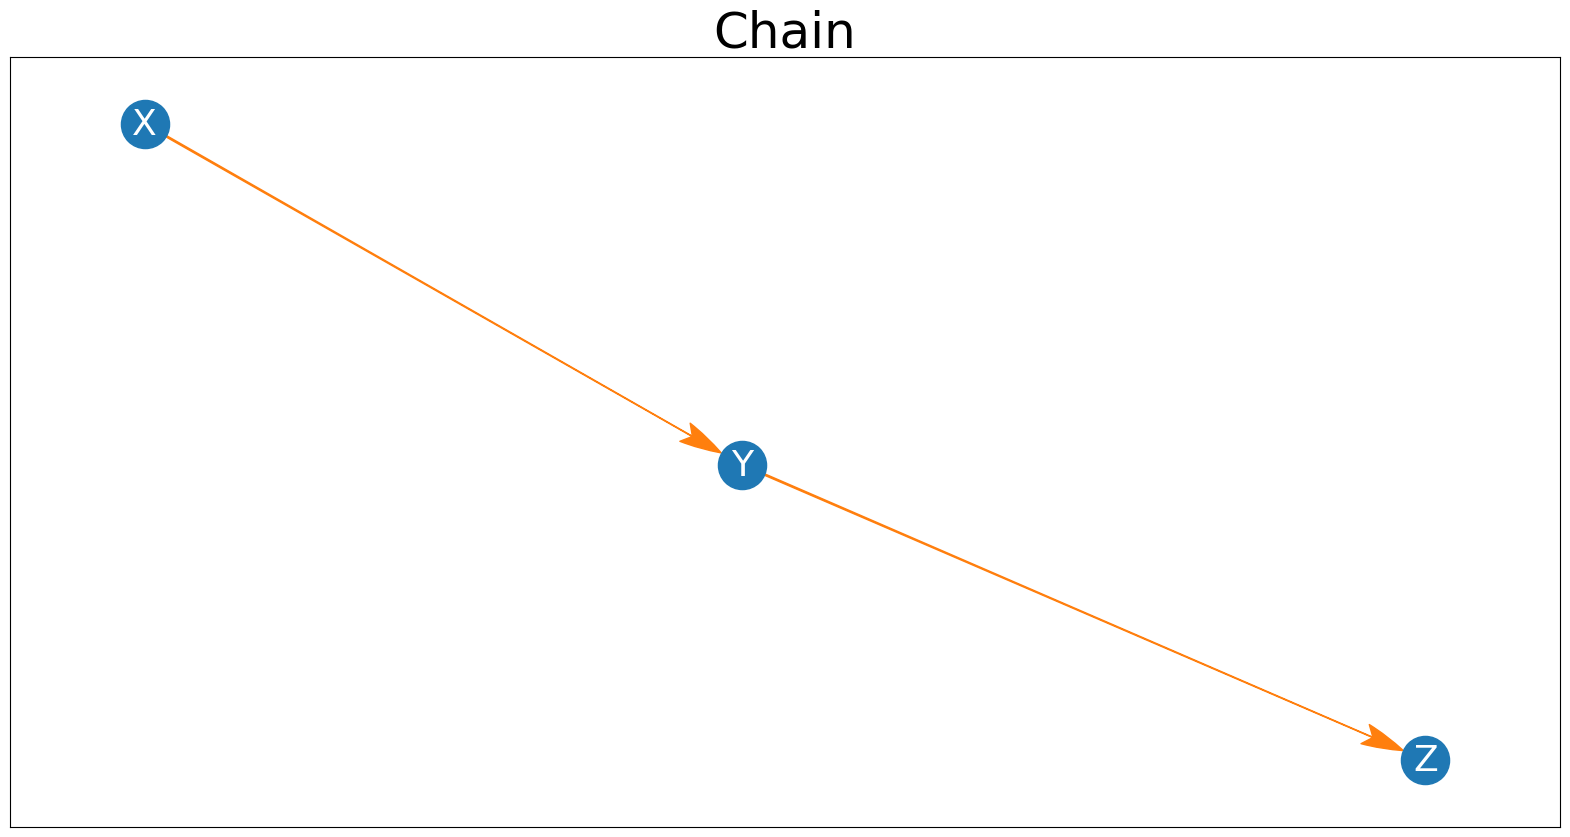

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle

# initiate graph object
plt.rcParams.update({"font.size":30})
G = nx.DiGraph()
G.add_edges_from([("X","Y"),("Y","Z")])
pos = nx.spring_layout(G)

# graph
fig,ax  = plt.subplots(figsize = (20,10))
nx.draw_networkx(G, pos,node_size = 1200, with_labels=True,  arrows=True, font_color = "white", font_size = 26, alpha = 1, width = 1, edge_color = "C1", arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
ax.set_title("Chain")

In [3]:
import random
import numpy as np
import pandas as pd


length = 100000
cols = ["X", "Y", "Z"]
chain = {col:[] for col in cols}
for i in range(length):
    chain["X"].append(np.random.normal(0, 1))
    chain["Y"].append(chain["X"][-1] * -1 + np.random.normal(0, 2))
    chain["Z"].append(chain["Y"][-1] * .5 + np.random.normal(0, 1))
chain = pd.DataFrame(chain)
chain

X         Y         Z
0     -1.346042  1.909059  1.248812
1     -0.980878 -2.497253 -1.227571
2      0.626366  1.350255  0.353569
3     -0.957361  2.188185  0.957203
4      1.138042 -2.080756 -2.246696
...         ...       ...       ...
99995  0.334256 -0.995789 -1.577022
99996 -0.472888  1.384615  2.261305
99997  0.970813 -0.041033  0.178400
99998 -0.474819  3.300880  1.396361
99999 -0.645952  3.692326  2.698868

[100000 rows x 3 columns]

In [4]:
chain.corr()

X         Y         Z
X  1.000000 -0.446937 -0.330613
Y -0.446937  1.000000  0.745424
Z -0.330613  0.745424  1.000000

C:\Users\tazee\datlib\plots.py:145: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(data, c = c, alpha = alpha, s = 200 / num_vars, ax=ax)


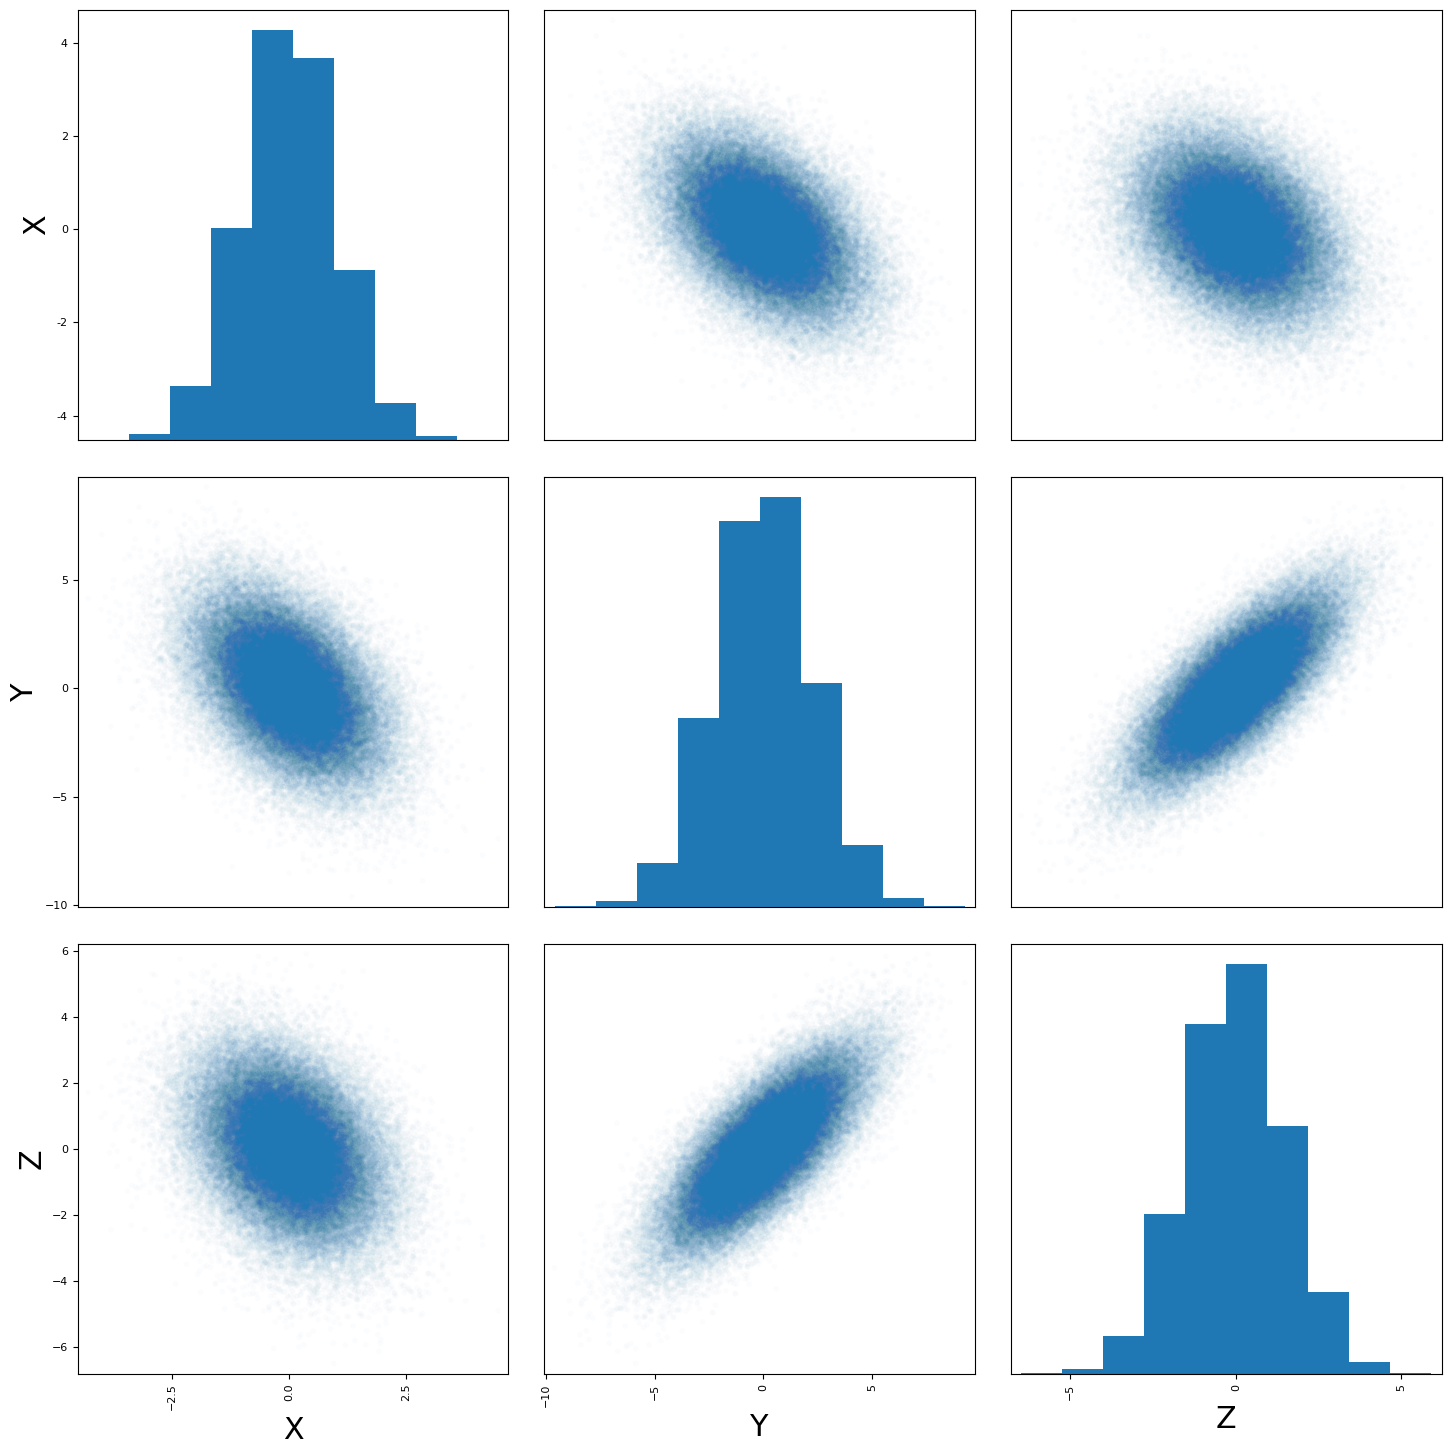

In [5]:
plt.rcParams.update({"font.size":30})
from datlib.plots import *
formatted_scatter_matrix(chain, alpha = 0.015)

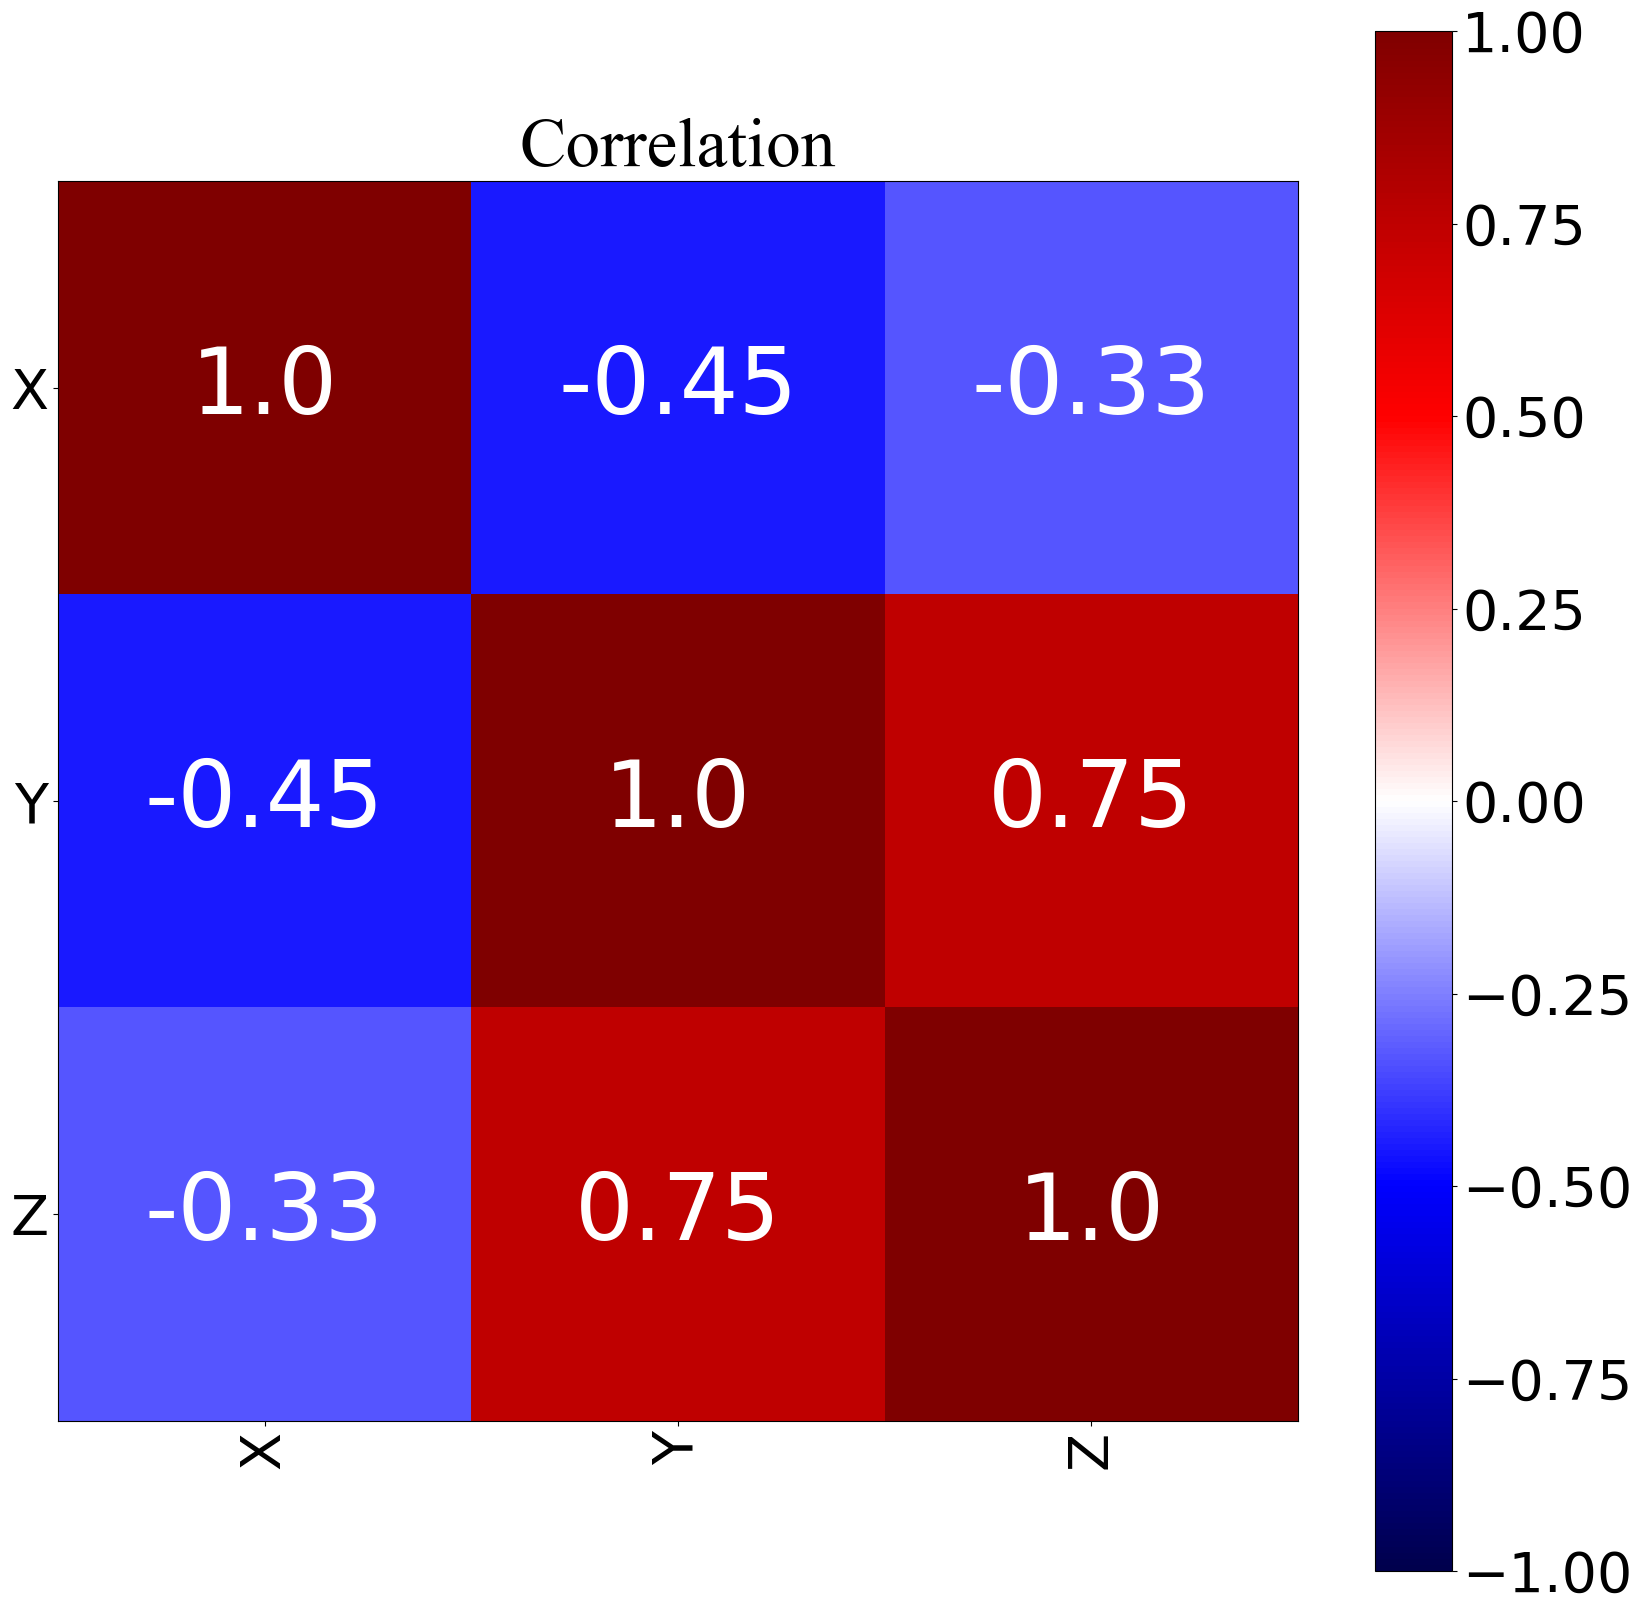

In [6]:
corr_matrix_heatmap(chain.corr(),
                    save_fig = False,
                    pp = None,
                    title = "Correlation")

If we control for $Y$, however, we see that that there is no longer any correlation between $X$ and $Z$. This is called a partial correlation. In the following matrix, partial correlations of each pair are calculated using the remaing variable as a control. We can interpret the result as:

$X \!\perp\!\!\!\perp Z|Y$ 

$Corr(X,Z|Y)\approx 0.00$

In [7]:
import statsmodels.api as sm

YZc = chain[["Y","Z"]]
YZc["Constant"] = 1
X = chain[["X"]]
# pass y_var as list for consistent structure
model = sm.OLS(X, YZc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                 1.248e+04
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:32:59   Log-Likelihood:            -1.3039e+05
No. Observations:              100000   AIC:                         2.608e+05
Df Residuals:                   99997   BIC:                         2.608e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y             -0.2006      0.002   -106.321      0.000      -0.204      -0.197
Z              0.0038      0.003      1.350      0.177      -0.002       0.009
Constant       0.0028      0.003      0.997      0.319      -0.003       0.008
==============================================================================
Omnibus:                        1.047   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.592   Jarque-Bera (JB):                1.036
Skew:                          -0.006   Prob(JB):                        0.596
Kurtosis:                       3.010   Cond. No.                         2.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
residuals = {}
def get_residuals(df):
    for y_var in df.keys():
        X_vars = list(df.keys())
        X_vars.remove(y_var)
        X = df[X_vars]
        # Initial estimate should include constant
        #   This won't be the case we regress the errors
        X["Constant"] = 1
        # pass y_var as list for consistent structure
        y = df[[y_var]]
        model = sm.OLS(y, X)
        results = model.fit()
        residuals["$\\epsilon_{" + y_var + "}$"] = results.resid
    return pd.DataFrame(residuals)
residuals = get_residuals(chain)
residuals

$\epsilon_{X}$  $\epsilon_{Y}$  $\epsilon_{Z}$
0           -0.970585       -0.029222        0.303646
1           -1.480043       -1.771669        0.031341
2            0.893112        1.306658       -0.321311
3           -0.524795        0.738585       -0.129559
4            0.726310        0.737693       -1.206442
...               ...             ...             ...
99995        0.137655        0.745376       -1.076056
99996       -0.206496       -1.125215        1.574494
99997        0.959094        0.265094        0.198357
99998        0.179316        1.655934       -0.249736
99999        0.081769        0.656859        0.857631

[100000 rows x 3 columns]

In [9]:
residuals.corr()

$\epsilon_{X}$  $\epsilon_{Y}$  $\epsilon_{Z}$
$\epsilon_{X}$        1.000000        0.318691       -0.004268
$\epsilon_{Y}$        0.318691        1.000000       -0.707910
$\epsilon_{Z}$       -0.004268       -0.707910        1.000000

In [10]:
def calculate_partial_corr(residuals):
    pcorr = residuals.corr() * -1
    for x in residuals.keys():        
        for y in residuals.keys():
            if x == y:
                pcorr[y][x] = 1
    return pcorr
# use variable names since are correcting correlations of residuals to reflect
#  partial correlation of respective variables 
chain_pcorr = calculate_partial_corr(residuals.rename(columns = {r:r[-3] for r in residuals.keys()}))
chain_pcorr.round(3)

X      Y      Z
X  1.000 -0.319  0.004
Y -0.319  1.000  0.708
Z  0.004  0.708  1.000

In [11]:
!pip install pingouin

In [12]:
import pingouin
chain.pcorr().round(3)

X      Y      Z
X  1.000 -0.319  0.004
Y -0.319  1.000  0.708
Z  0.004  0.708  1.000

In [13]:
pingouin.partial_corr(data=chain, x='X', y='Z', covar='Y').round(3)

n      r         CI95%  p-val
pearson  100000  0.004  [-0.0, 0.01]  0.177

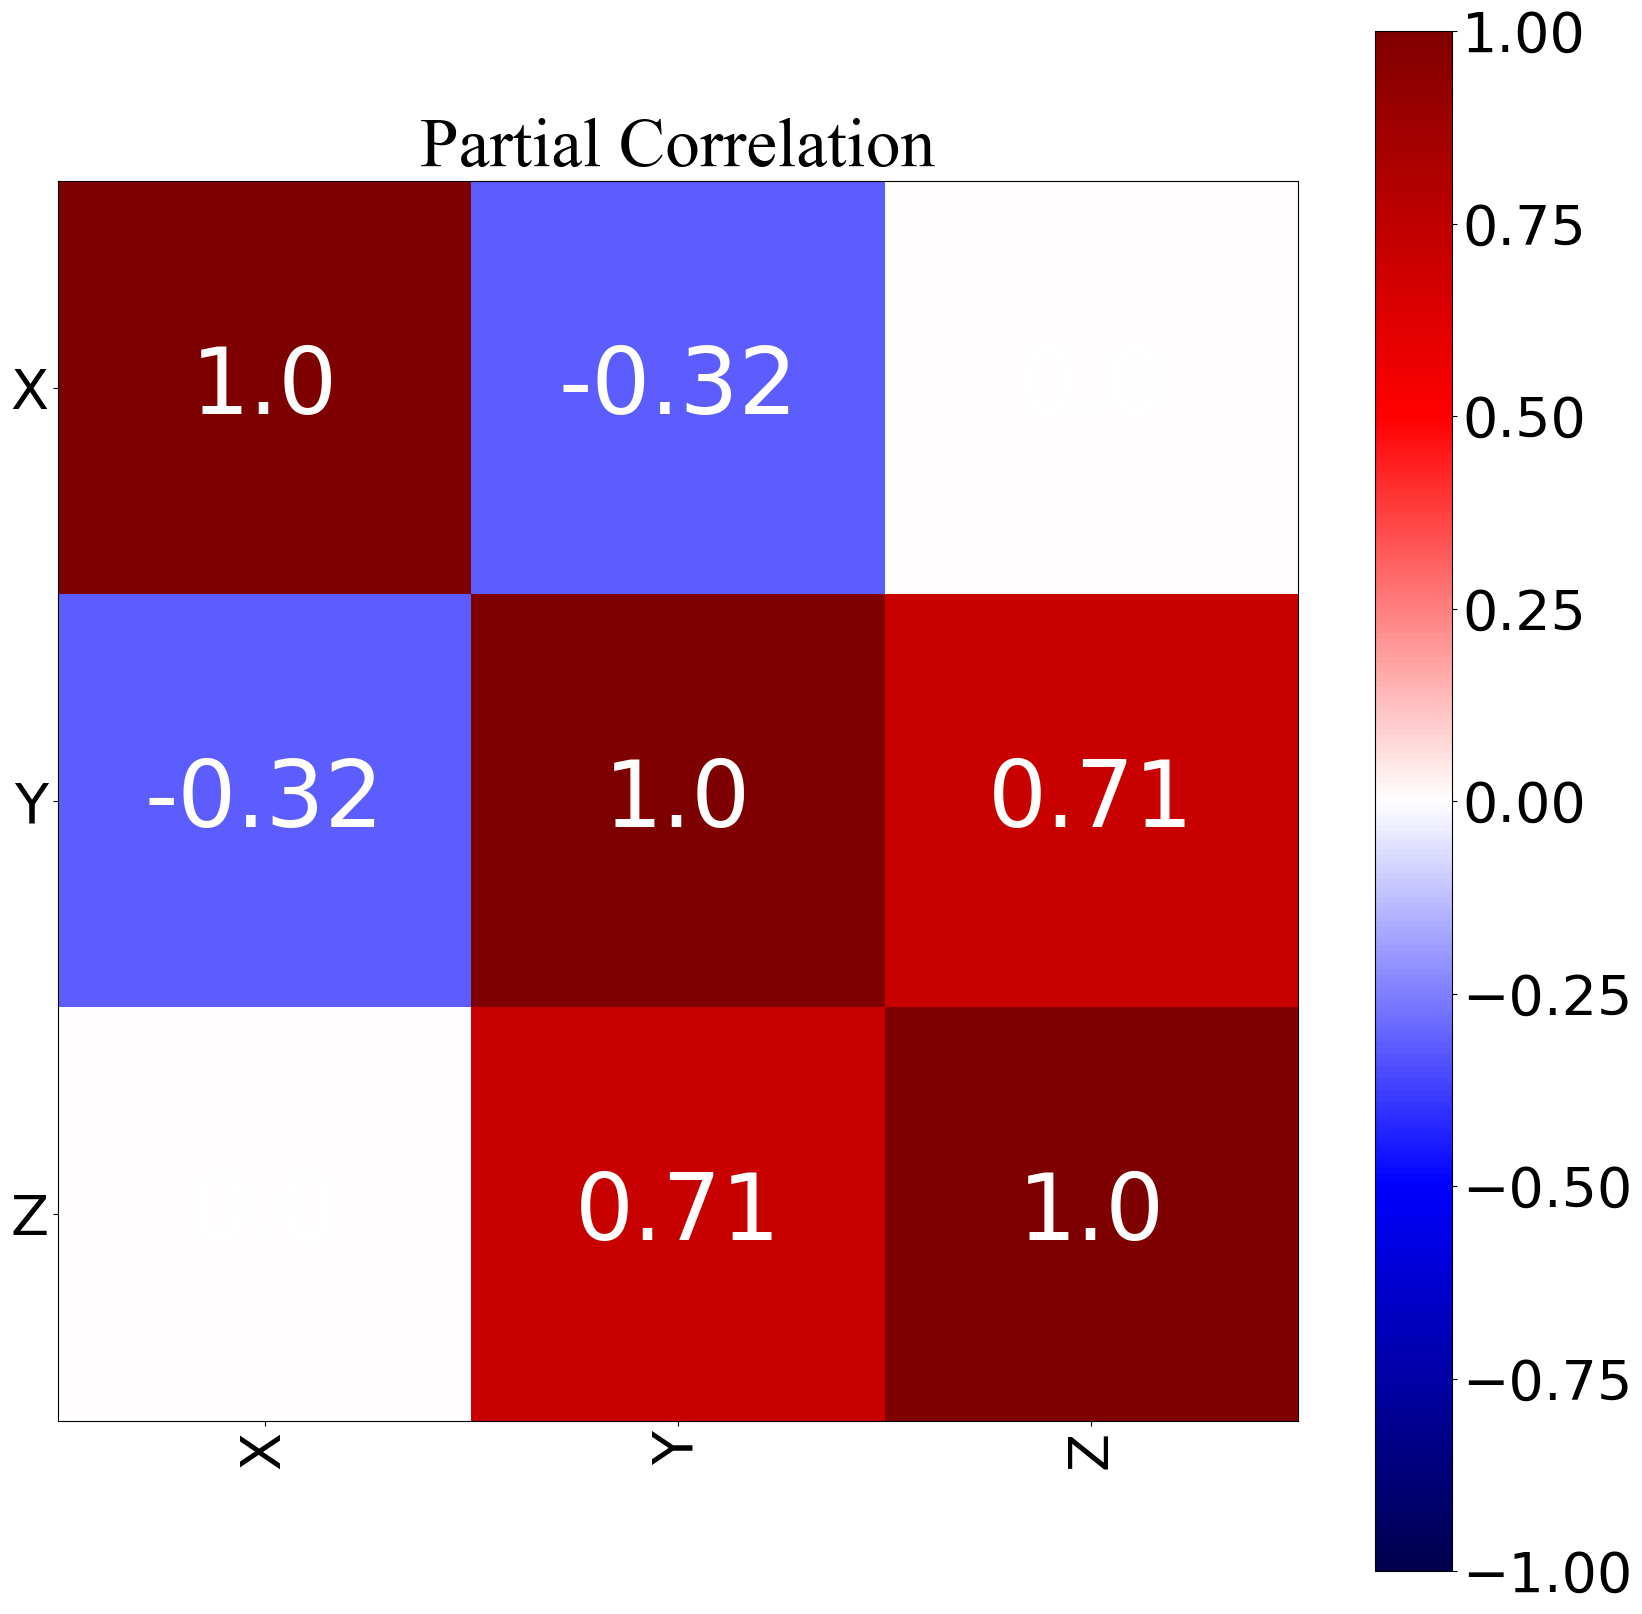

In [14]:
corr_matrix_heatmap(chain_pcorr,
                    save_fig = False,
                    pp = None, 
                    title = "Partial Correlation")

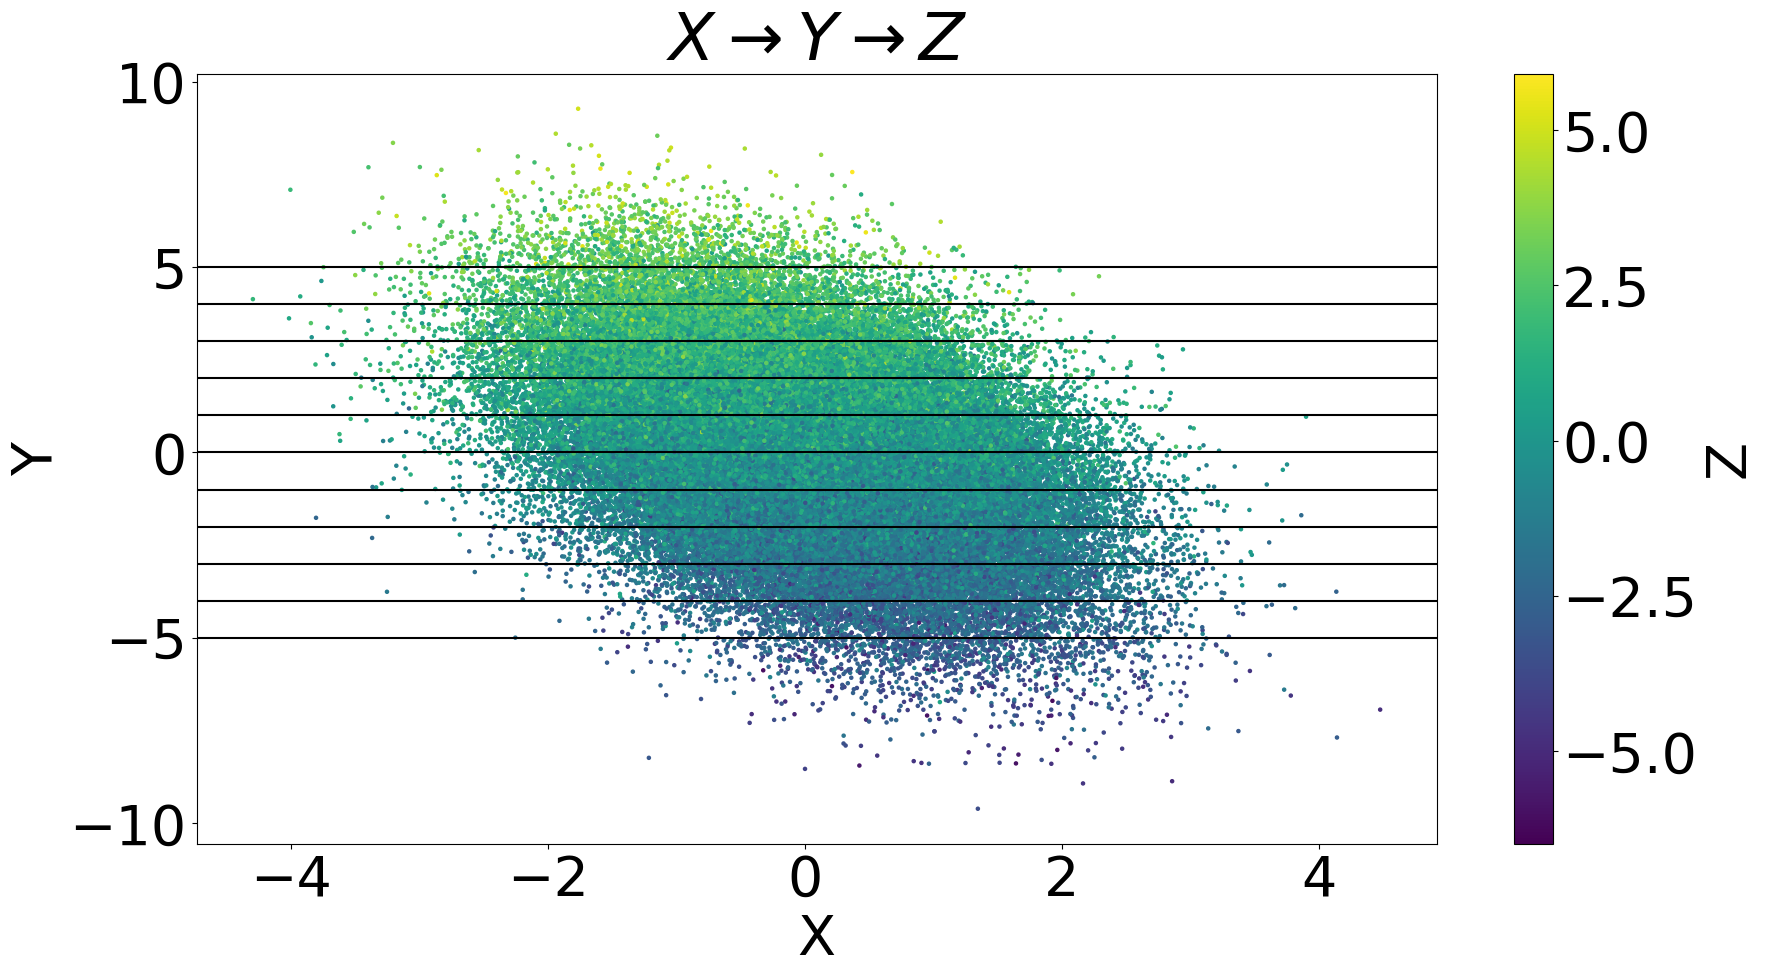

In [15]:
fig,ax = plt.subplots(figsize = (20,10))
chain.plot.scatter(x = "X", y = "Y", c = "Z", cmap = "viridis", s = 5, ax = ax)
ax.set_title("$X \\rightarrow Y \\rightarrow Z$")
for i in range(-5,6): ax.axhline(i, c = "k")

# Forks

Suppose that a variable $X$ generates variables $Y$ and $Z$, thus yielding $Y\leftarrow X \rightarrow Z$. And suppose that $Y$ and $Z$ do not directly related. Again, all three variables will be correlated. However, in the case of this fork, correlation between $Y$ and $Z$ is due to confounding from the common cause of $X$. $Y$ and $Z$ are D-separated by $X$.

Text(0.5, 1.0, 'Fork')

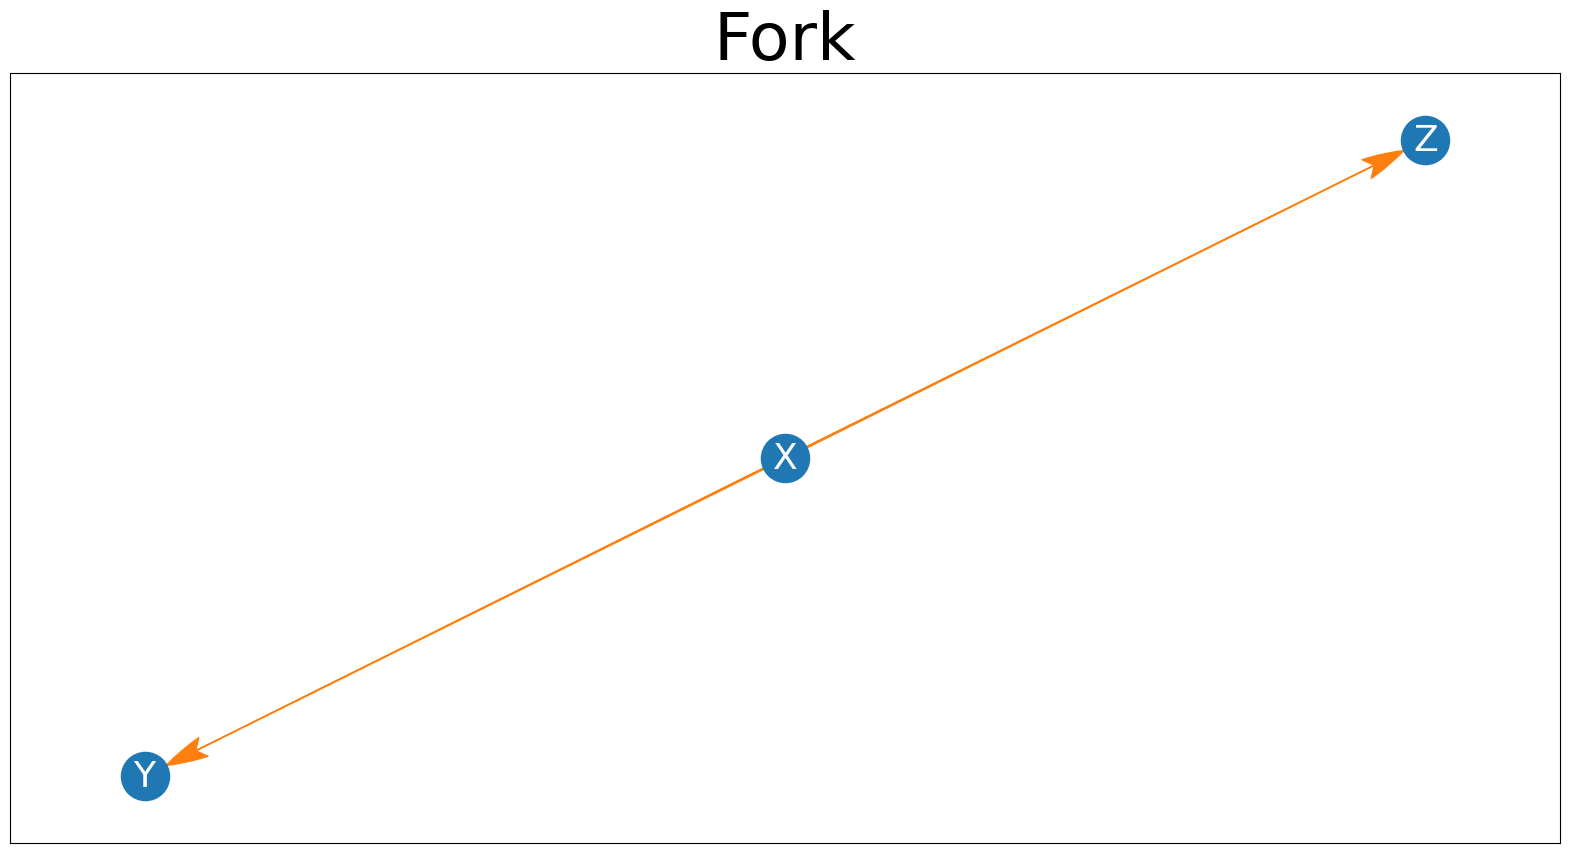

In [16]:
G = nx.DiGraph()
G.add_edges_from([("X","Y"),("X","Z")])
pos = nx.spring_layout(G)#, k = 5/(len(sig_corr.keys())**.5))

fig,ax  = plt.subplots(figsize = (20,10))
# plt.title(title, fontsize = 30)
nx.draw_networkx(G, pos,node_size = 1200,
     with_labels=True,  arrows=True,
     font_color = "white",
     font_size = 26, alpha = 1,
     width = 1, edge_color = "C1",
     arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                ax = ax)
ax.set_title("Fork")

In [17]:
fork = {col:[] for col in cols}
for i in range(length):
    fork["X"].append(np.random.normal(0, 1))
    fork["Y"].append(fork["X"][-1] + np.random.normal(0, 1))
    fork["Z"].append(fork["X"][-1] * 2 + np.random.normal(0, 1))
fork = pd.DataFrame(fork)
fork

X         Y         Z
0      1.278839  1.433788  3.234378
1      1.919601  1.991920  3.125001
2      0.627874  0.087052  1.560106
3     -0.947134 -0.759589 -2.070624
4      2.269978  1.010019  3.953932
...         ...       ...       ...
99995 -0.117437  1.817070  0.575649
99996  1.316573  2.178882  1.902828
99997 -0.536511 -2.273508 -0.903702
99998  0.273073  0.041606  1.322756
99999 -0.042165  0.081736 -0.661492

[100000 rows x 3 columns]

In [18]:
fork.corr()

X         Y         Z
X  1.000000  0.707825  0.894384
Y  0.707825  1.000000  0.631806
Z  0.894384  0.631806  1.000000

In [19]:
XZc = fork[["X","Z"]]
XZc["Constant"] = 1
Y = fork[["Y"]]
# pass y_var as list for consistent structure
model = sm.OLS(Y, XZc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                 5.020e+04
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:33:37   Log-Likelihood:            -1.4207e+05
No. Observations:              100000   AIC:                         2.841e+05
Df Residuals:                   99997   BIC:                         2.842e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.0134      0.007    142.864      0.000       0.999       1.027
Z             -0.0040      0.003     -1.262      0.207      -0.010       0.002
Constant       0.0019      0.003      0.611      0.541      -0.004       0.008
==============================================================================
Omnibus:                        1.101   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                1.108
Skew:                          -0.002   Prob(JB):                        0.575
Kurtosis:                       2.984   Cond. No.                         5.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
fork.pcorr()

X         Y         Z
X  1.000000  0.411716  0.816700
Y  0.411716  1.000000 -0.003992
Z  0.816700 -0.003992  1.000000

In [21]:
pingouin.partial_corr(data=fork, x='Y', y='Z', covar='X').round(3)

n      r         CI95%  p-val
pearson  100000 -0.004  [-0.01, 0.0]  0.207

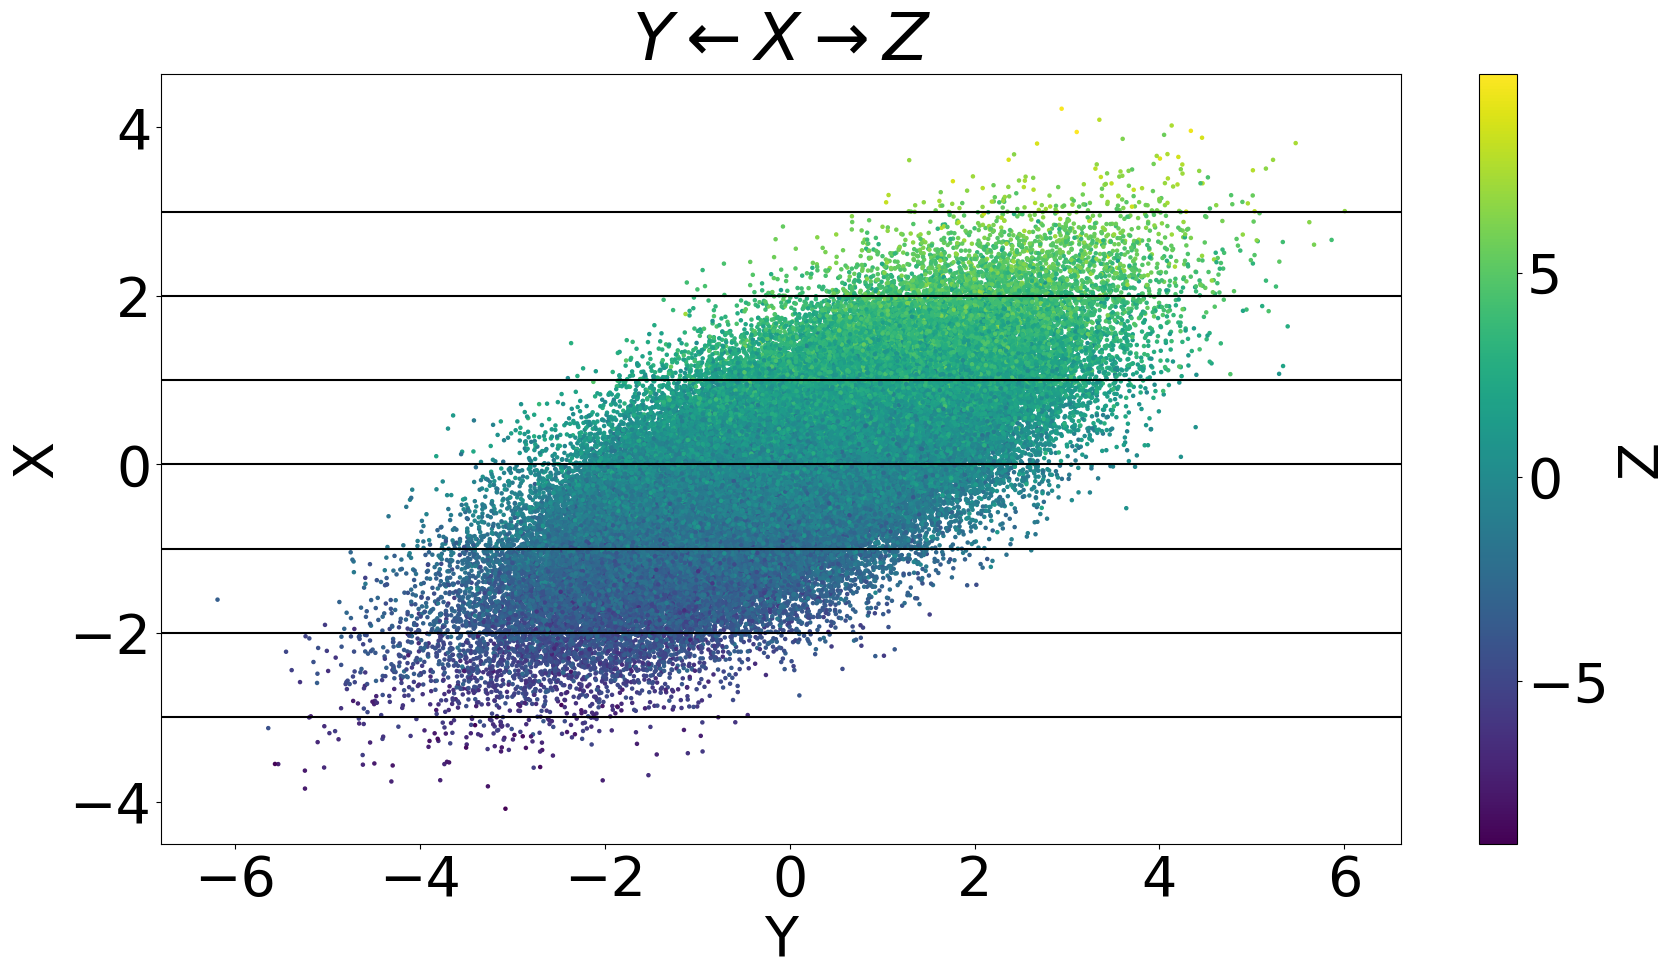

In [22]:
fig,ax = plt.subplots(figsize = (20,10))
fork.plot.scatter(x = "Y", y = "X", c = "Z",s = 5, cmap = "viridis", ax = ax)
ax.set_title("$Y \\leftarrow X \\rightarrow Z$")
for i in range(-3,4): ax.axhline(i, c = "k")

# Colliders

Text(0.5, 1.0, 'Collider')

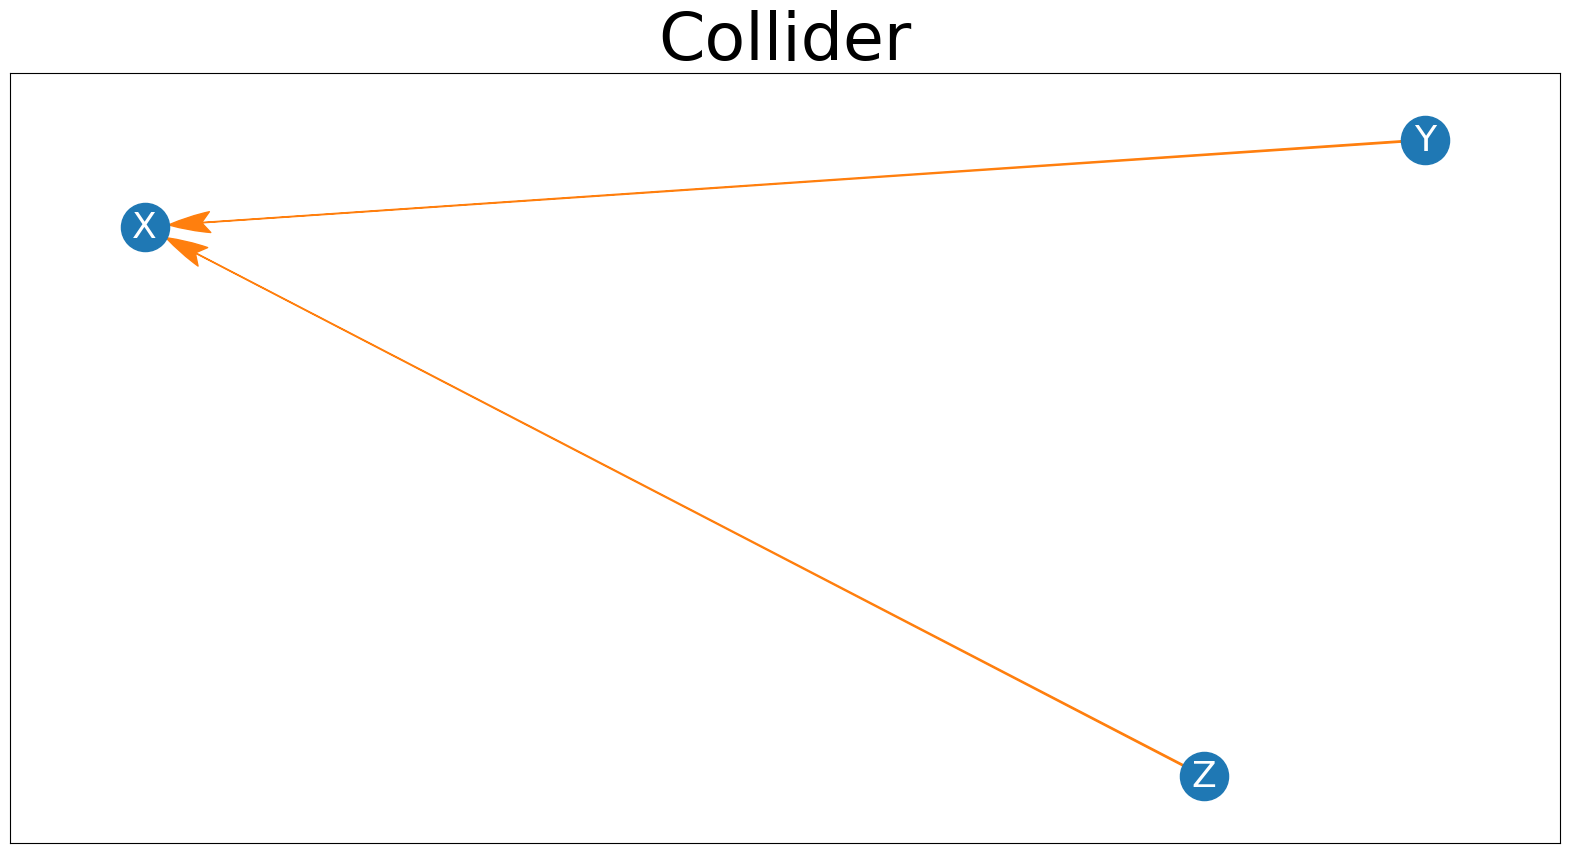

In [23]:
G = nx.DiGraph()
G.add_edges_from([("Y","X"),("Z","X")])
pos = nx.spring_layout(G)#, k = 5/(len(sig_corr.keys())**.5))

fig,ax  = plt.subplots(figsize = (20,10))
# plt.title(title, fontsize = 30)
nx.draw_networkx(G, pos,node_size = 1200,
     with_labels=True,  arrows=True,
     font_color = "white",
     font_size = 26, alpha = 1,
     width = 1, edge_color = "C1",
     arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                ax = ax)
ax.set_title("Collider")

In [24]:
collider = {col:[] for col in cols}
for i in range(length):
    collider["Y"].append(np.random.normal(0, 1))
    collider["Z"].append(np.random.normal(0, 1))
    collider["X"].append(collider["Y"][-1] * -.5 + collider["Z"][-1] * .5 + np.random.normal(0, 1))
collider = pd.DataFrame(collider)
collider

X         Y         Z
0     -0.534701 -1.122052 -1.136071
1     -1.268002  0.978197  0.822278
2     -0.034873  2.241062  0.724008
3     -1.631767  0.281058 -0.519831
4      1.824724 -0.761025  0.775707
...         ...       ...       ...
99995  0.151076  1.419607  0.798648
99996 -0.352080 -0.758952 -0.932991
99997 -1.095683 -0.736327 -1.092100
99998 -2.327441  1.206998 -1.121843
99999 -2.170224  0.107939 -1.989727

[100000 rows x 3 columns]

In [25]:
collider.pcorr()

X         Y         Z
X  1.000000 -0.447175  0.444932
Y -0.447175  1.000000  0.201072
Z  0.444932  0.201072  1.000000

Text(0.5, 1.0, '$Y \\rightarrow X \\leftarrow Z$')

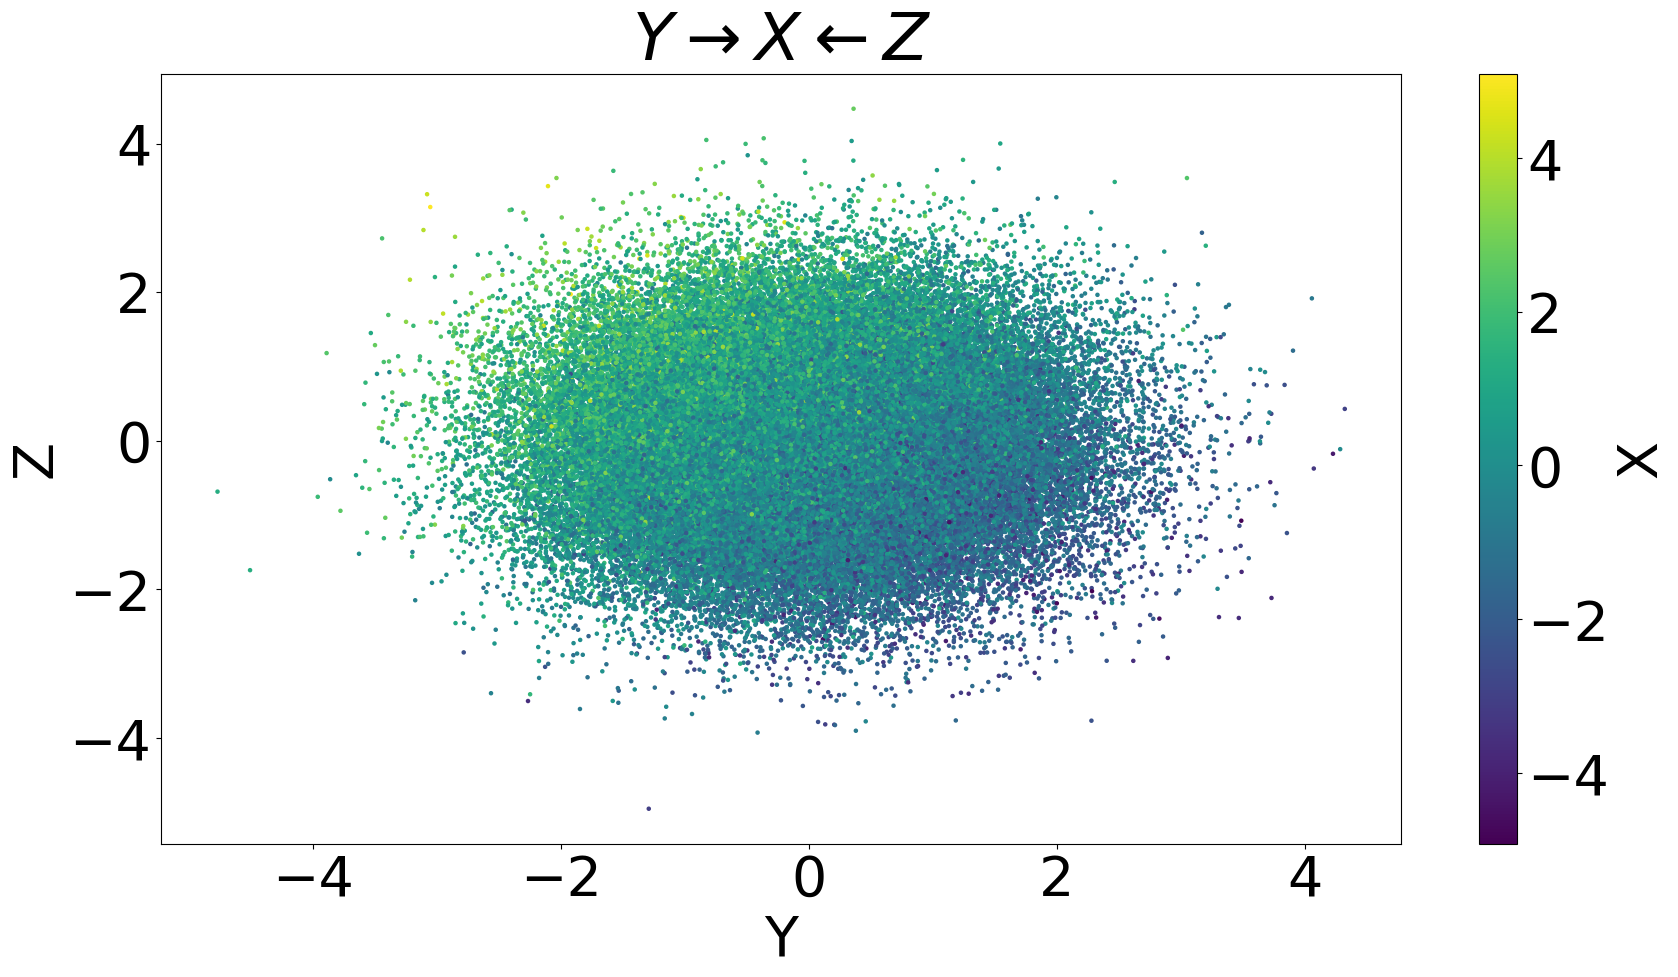

In [26]:
fig,ax = plt.subplots(figsize = (20,10))
collider.plot.scatter(x = "Y", y = "Z", c = "X",s = 5, cmap = "viridis", ax = ax)
ax.set_title("$Y \\rightarrow X \\leftarrow Z$")

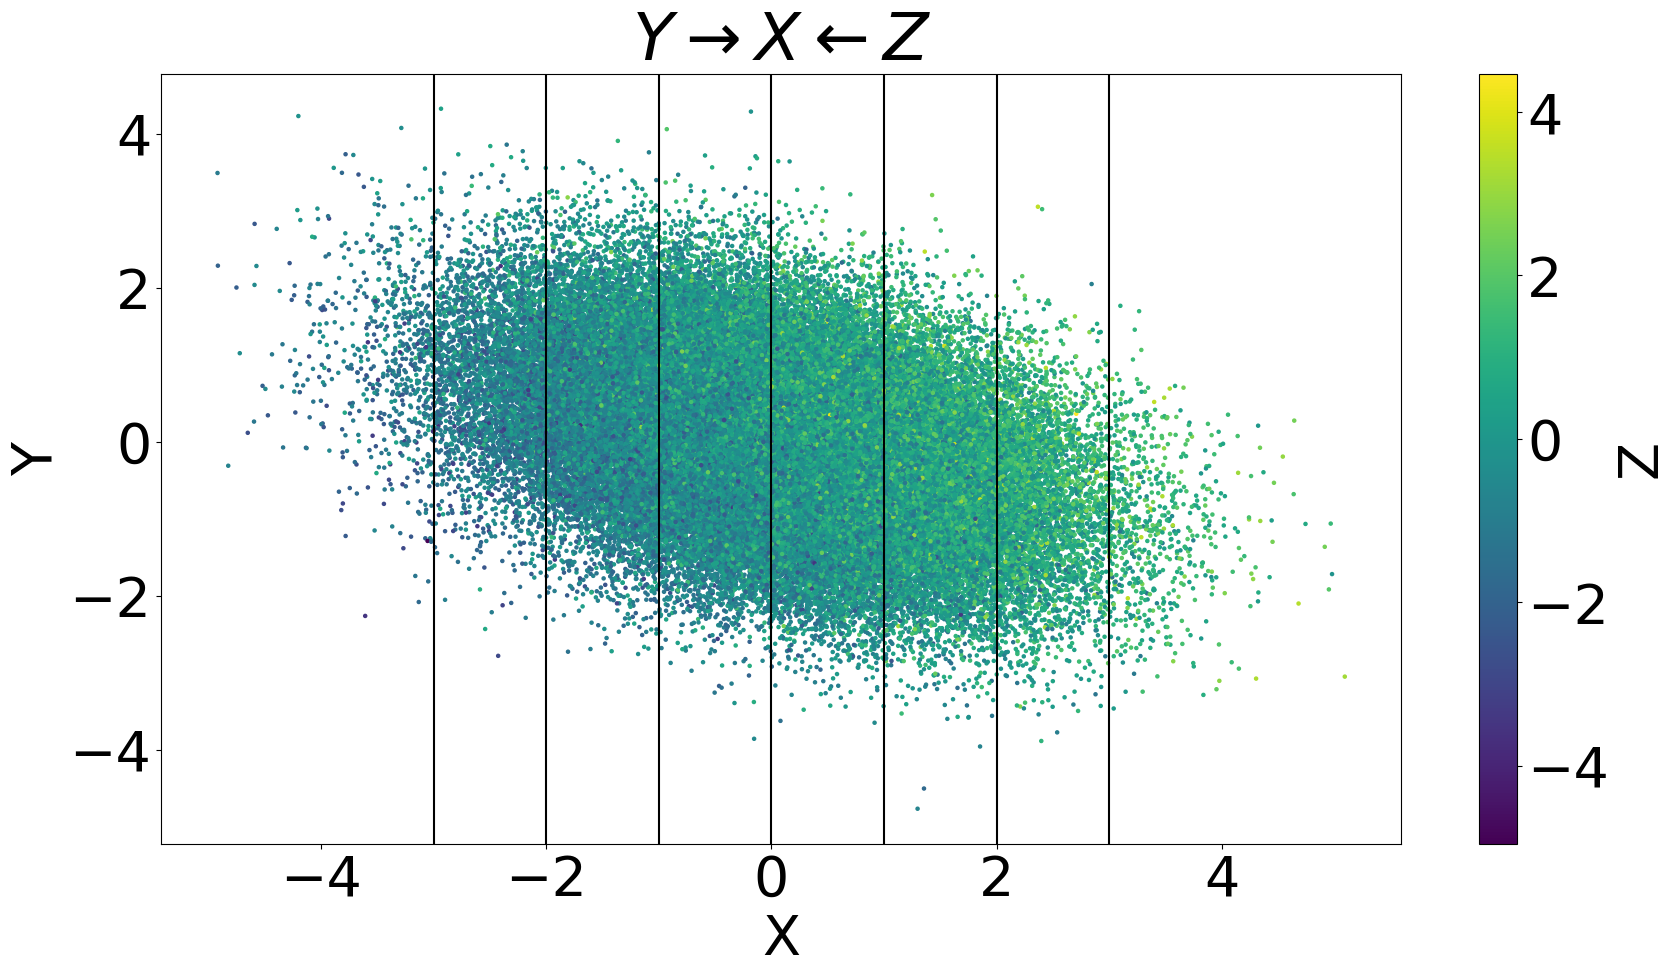

In [27]:
fig,ax = plt.subplots(figsize = (20,10))
collider.plot.scatter(x = "X", y = "Y", c = "Z",s = 5, cmap = "viridis", ax = ax)
ax.set_title("$Y \\rightarrow X \\leftarrow Z$")
for i in range(-3,4): ax.axvline(i, c = "k")

# Problem with confounding

### Backdoor

Text(0.5, 1.0, 'Backdoor Criterion')

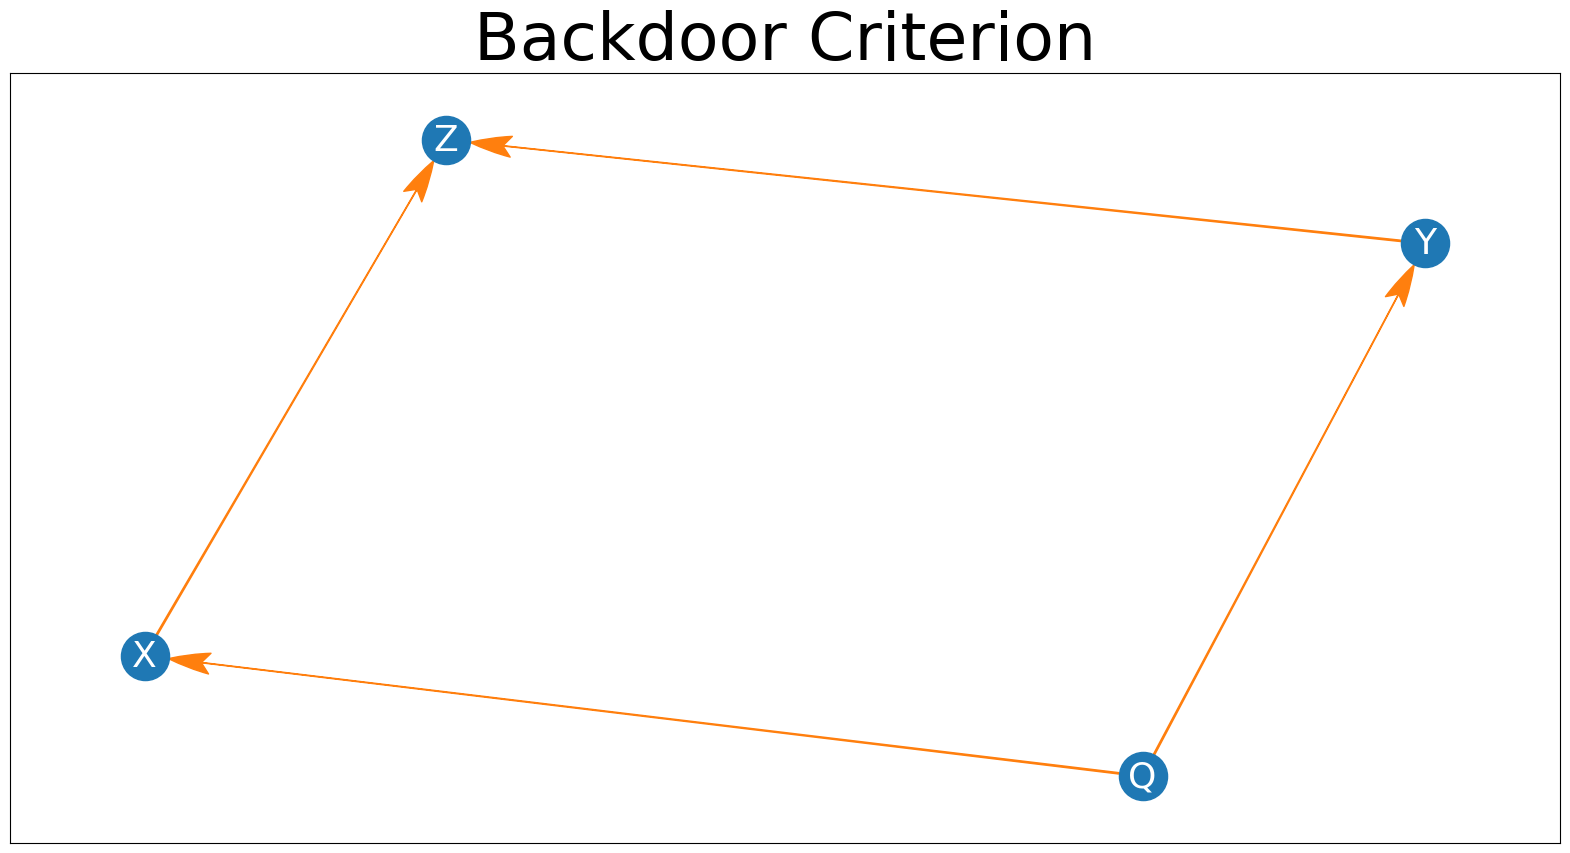

In [32]:
G = nx.DiGraph()
G.add_edges_from([("Q","X"),("Q","Y"), ("X","Z"),("Y","Z")])
pos = nx.spring_layout(G)#, k = 5/(len(sig_corr.keys())**.5))

fig,ax  = plt.subplots(figsize = (20,10))
# plt.title(title, fontsize = 30)
nx.draw_networkx(G, pos,node_size = 1200,
     with_labels=True,  arrows=True,
     font_color = "white",
     font_size = 26, alpha = 1,
     width = 1, edge_color = "C1",
     arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                ax = ax)
ax.set_title("Backdoor Criterion")

In [34]:
cols = ["Q", "X", "Y", "Z"]
mu = 0
sigma = 1

backdoor = {col:[] for col in cols}
for i in range(length):
    backdoor["Q"].append(np.random.normal(mu, sigma))
    backdoor["X"].append(3 * backdoor["Q"][-1]  + np.random.normal(mu, sigma ))
    backdoor["Y"].append(backdoor["Q"][-1] * -1 +  np.random.normal(mu, sigma))
    backdoor["Z"].append(1.5 * backdoor["X"][-1] -  backdoor["Y"][-1] * 2 +  np.random.normal(mu,  sigma))

backdoor = pd.DataFrame(backdoor)
backdoor

Q         X         Y         Z
0      0.340229  1.832399 -1.315168  6.061833
1      0.354502  1.220918  0.945683 -0.457219
2      0.276476  2.580524 -0.922836  6.825595
3     -0.068173 -1.279201  1.070927 -3.661101
4      0.305304  1.217036  0.537660  2.699668
...         ...       ...       ...       ...
99995 -0.658165 -2.551432  3.081460 -9.259601
99996 -0.029480  2.023190  0.549509  1.201922
99997 -1.243964 -2.418187  1.255872 -4.731223
99998  0.290490  1.225982 -2.570381  6.469877
99999  0.159412 -0.122657 -1.249064  2.641563

[100000 rows x 4 columns]

In [35]:
import statsmodels.api as sm

QXYc = backdoor[["Q", "X", "Y"]]
QXYc["Constant"] = 1
Z = backdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, QXYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.622e+06
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:36:20   Log-Likelihood:            -1.4190e+05
No. Observations:              100000   AIC:                         2.838e+05
Df Residuals:                   99996   BIC:                         2.838e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -0.0094      0.010     -0.897      0.370      -0.030       0.011
X              1.5000      0.003    474.135      0.000       1.494       1.506
Y             -2.0055      0.003   -631.767      0.000      -2.012      -1.999
Constant       0.0023      0.003      0.725      0.469      -0.004       0.008
==============================================================================
Omnibus:                        2.706   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                2.677
Skew:                           0.002   Prob(JB):                        0.262
Kurtosis:                       2.975   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Frontdoor Criterion                             

In [37]:
import random
import numpy as np
import pandas as pd

cols = ["Q", "X", "Y", "Z"]
mu = 0
sigma = 1


frontdoor = {col:[] for col in cols}
for i in range(length):
    frontdoor["Q"].append(np.random.normal(mu, sigma))
    frontdoor["X"].append(10 * frontdoor["Q"][-1]  + np.random.normal(mu, sigma ))
    frontdoor["Y"].append(frontdoor["X"][-1] * 2 +  np.random.normal(mu, sigma))
    frontdoor["Z"].append(frontdoor["Q"][-1] * -1 +  frontdoor["Y"][-1] +  np.random.normal(mu,  sigma))

frontdoor = pd.DataFrame(frontdoor)
frontdoor

Q          X          Y          Z
0      1.871904  19.371366  38.103775  35.854644
1      0.082097   0.813374   1.446635   2.794696
2      0.713179   7.069796  14.678210  14.682756
3      0.182832   2.158949   4.768890   5.886192
4     -0.234735  -2.805867  -5.539020  -4.490079
...         ...        ...        ...        ...
99995  0.408774   4.268352   8.817362   9.720157
99996 -0.267430  -2.153308  -4.549126  -4.975529
99997  0.036643  -0.236118   0.749212   1.411921
99998  0.115846   0.768820   0.350136  -1.686249
99999 -0.272957  -2.736352  -4.107947  -4.992791

[100000 rows x 4 columns]

Text(0.5, 1.0, 'Frontdoor Criterion')

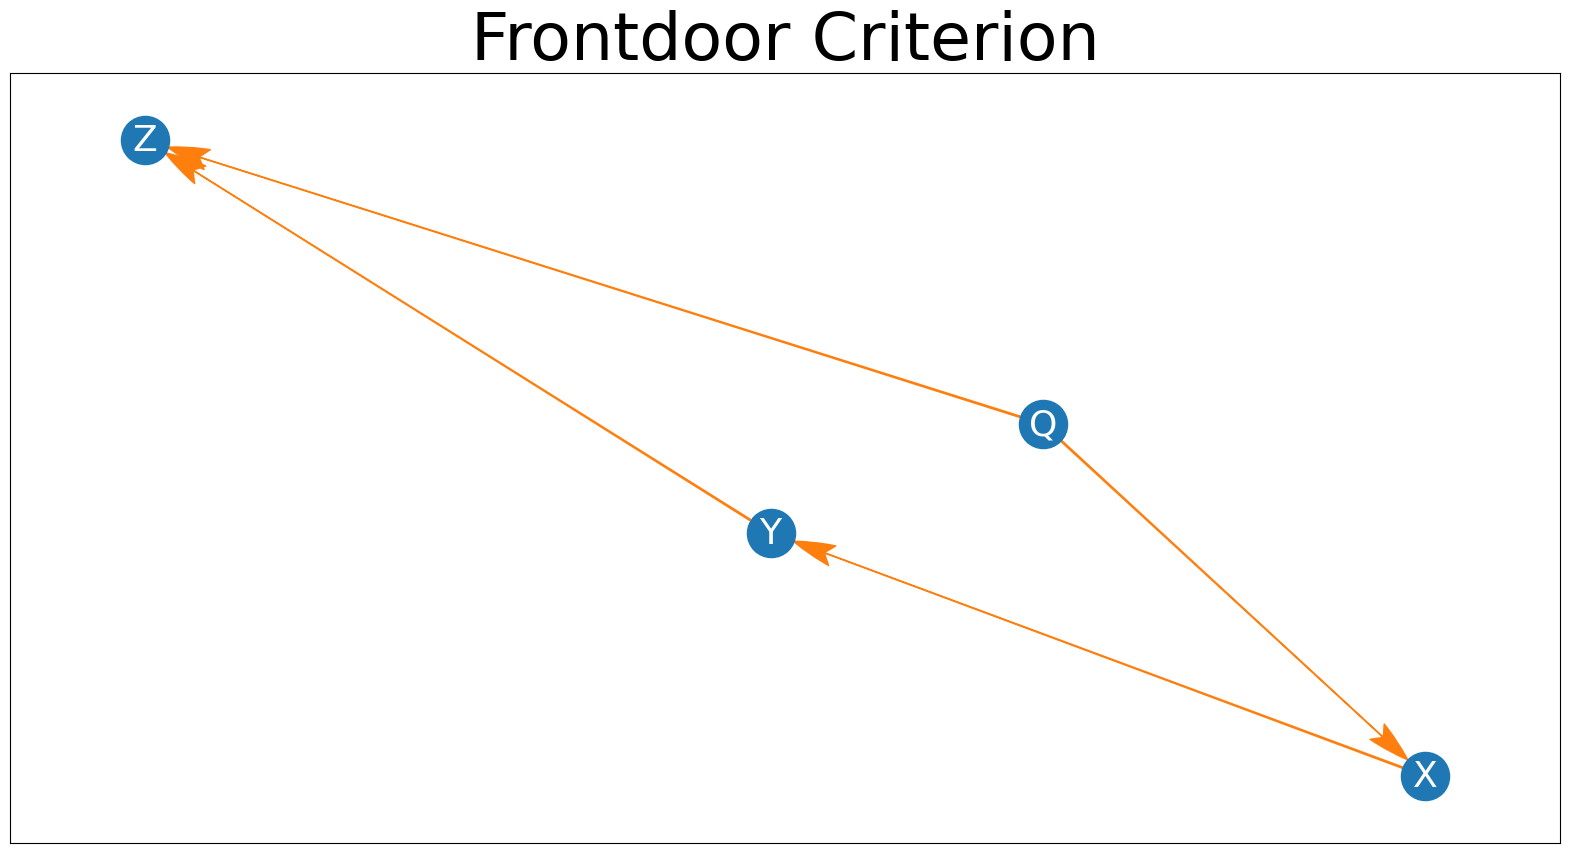

In [49]:
G = nx.DiGraph()
G.add_edges_from([("Q","X"),("Q","Z"), ("X","Y"),("Y","Z")])
pos = nx.spring_layout(G)#, k = 5/(len(sig_corr.keys())**.5))

fig,ax  = plt.subplots(figsize = (20,10))
# plt.title(title, fontsize = 30)
nx.draw_networkx(G, pos,node_size = 1200,
     with_labels=True,  arrows=True,
     font_color = "white",
     font_size = 26, alpha = 1,
     width = 1, edge_color = "C1",
     arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                ax = ax)
ax.set_title("Frontdoor Criterion")

In [38]:
import statsmodels.api as sm

Xc = frontdoor[["X"]]
Xc["Constant"] = 1
Z = frontdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, Xc)
results = model.fit()
results.summary()

C:\Users\tazee\AppData\Local\Temp\ipykernel_9500\1196884393.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.808e+07
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:37:32   Log-Likelihood:            -1.7661e+05
No. Observations:              100000   AIC:                         3.532e+05
Df Residuals:                   99998   BIC:                         3.532e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.9015      0.000   4252.643      0.000       1.901       1.902
Constant      -0.0092      0.004     -2.062      0.039      -0.018      -0.000
==============================================================================
Omnibus:                        6.999   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                7.120
Skew:                          -0.011   Prob(JB):                       0.0284
Kurtosis:                       3.035   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
XYc = frontdoor[["X", "Y"]]
XYc["Constant"] = 1
Z = frontdoor[["Z"]]
model = sm.OLS(Z, Xc)
results = model.fit()
results.summary()

C:\Users\tazee\AppData\Local\Temp\ipykernel_9500\1620809561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XYc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.808e+07
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:38:31   Log-Likelihood:            -1.7661e+05
No. Observations:              100000   AIC:                         3.532e+05
Df Residuals:                   99998   BIC:                         3.532e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.9015      0.000   4252.643      0.000       1.901       1.902
Constant      -0.0092      0.004     -2.062      0.039      -0.018      -0.000
==============================================================================
Omnibus:                        6.999   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                7.120
Skew:                          -0.011   Prob(JB):                       0.0284
Kurtosis:                       3.035   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
QXc = frontdoor[["Q","X"]]
QXc["Constant"] = 1
Z = frontdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, QXc)
results = model.fit()
results.summary()

C:\Users\tazee\AppData\Local\Temp\ipykernel_16196\396511961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QXc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 9.073e+06
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:57:47   Log-Likelihood:            -1.7654e+05
No. Observations:              100000   AIC:                         3.531e+05
Df Residuals:                   99997   BIC:                         3.531e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -0.9787      0.045    -21.778      0.000      -1.067      -0.891
X              1.9973      0.004    446.612      0.000       1.988       2.006
Constant      -0.0006      0.004     -0.136      0.892      -0.009       0.008
==============================================================================
Omnibus:                        4.524   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.581
Skew:                           0.008   Prob(JB):                        0.101
Kurtosis:                       3.029   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
XYc = frontdoor[["X", "Y"]]
XYc["Constant"] = 1
Z = frontdoor[["Z"]]
model = sm.OLS(Z, XYc)
results = model.fit()
results.summary()

C:\Users\tazee\AppData\Local\Temp\ipykernel_9500\3814303157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XYc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.808e+07
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:38:47   Log-Likelihood:            -1.4209e+05
No. Observations:              100000   AIC:                         2.842e+05
Df Residuals:                   99997   BIC:                         2.842e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.0944      0.006    -14.889      0.000      -0.107      -0.082
Y              0.9979      0.003    315.344      0.000       0.992       1.004
Constant      -0.0040      0.003     -1.272      0.203      -0.010       0.002
==============================================================================
Omnibus:                        3.778   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.772
Skew:                          -0.012   Prob(JB):                        0.152
Kurtosis:                       3.017   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
import statsmodels.api as sm

QXYc = frontdoor[["Q","X","Y"]]
QXYc["Constant"] = 1
Z = frontdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, QXYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.215e+07
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:58:58   Log-Likelihood:            -1.4182e+05
No. Observations:              100000   AIC:                         2.836e+05
Df Residuals:                   99996   BIC:                         2.837e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -0.9932      0.032    -31.274      0.000      -1.055      -0.931
X             -0.0051      0.007     -0.717      0.473      -0.019       0.009
Y              1.0021      0.003    316.610      0.000       0.996       1.008
Constant       0.0002      0.003      0.054      0.957      -0.006       0.006
==============================================================================
Omnibus:                        0.421   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.410
Skew:                          -0.000   Prob(JB):                        0.815
Kurtosis:                       3.010   Cond. No.                         227.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
QXc = frontdoor[["Q", "X"]]
QXc["Constant"] = 1
Z = frontdoor[["Z"]]
model = sm.OLS(Z, QXc)
results = model.fit()
results.summary()

C:\Users\tazee\AppData\Local\Temp\ipykernel_9500\2209165990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QXc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 9.086e+06
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:39:04   Log-Likelihood:            -1.7637e+05
No. Observations:              100000   AIC:                         3.527e+05
Df Residuals:                   99997   BIC:                         3.528e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -0.9854      0.045    -21.980      0.000      -1.073      -0.898
X              1.9991      0.004    448.036      0.000       1.990       2.008
Constant      -0.0089      0.004     -1.987      0.047      -0.018      -0.000
==============================================================================
Omnibus:                        6.901   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                7.032
Skew:                          -0.010   Prob(JB):                       0.0297
Kurtosis:                       3.036   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
QXYc = frontdoor[["Q","X","Y"]]
QXYc["Constant"] = 1
Z = frontdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, QXYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.218e+07
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:39:31   Log-Likelihood:            -1.4159e+05
No. Observations:              100000   AIC:                         2.832e+05
Df Residuals:                   99996   BIC:                         2.832e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -1.0068      0.032    -31.797      0.000      -1.069      -0.945
X              0.0049      0.007      0.699      0.485      -0.009       0.019
Y              0.9981      0.003    317.000      0.000       0.992       1.004
Constant      -0.0037      0.003     -1.161      0.245      -0.010       0.003
==============================================================================
Omnibus:                        3.515   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                3.508
Skew:                          -0.012   Prob(JB):                        0.173
Kurtosis:                       3.016   Cond. No.                         226.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# Generate Artificial Data to be used to detect directed acyclic graph

import random
import numpy as np
import pandas as pd

length = 100000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0
sigma = 5


lst_dct = {col:[] for col in cols}
for i in range(length):
    lst_dct["P"].append(np.random.normal(mu, .5 * sigma))
    lst_dct["Q"].append(np.random.normal(mu, sigma))
    lst_dct["X"].append(3 * lst_dct["Q"][-1]  + np.random.normal(mu, sigma ))
    lst_dct["Y"].append(lst_dct["Q"][-1] * -1 +  np.random.normal(mu, sigma))
    lst_dct["Z"].append(
        lst_dct["P"][-1] * 2 +  1.5 * lst_dct["X"][-1] -  lst_dct["Y"][-1] * 2 +  np.random.normal(mu,  sigma))

df = pd.DataFrame(lst_dct)
df

P          Q          X          Y          Z
0      2.516570  -1.404207 -10.356015   2.102390 -16.213263
1      1.808645   7.418846  16.728251   7.937311  14.149664
2      0.092469  10.288746  35.504214 -16.247461  90.272803
3      0.364937 -11.236493 -30.361272  19.276663 -77.526266
4     -0.346270  -1.461277  -8.241306  -2.482654  -6.440807
...         ...        ...        ...        ...        ...
99995 -1.040918   0.884733   2.245619  -0.476693 -17.400688
99996  3.855107  -8.011140 -36.228754   4.556256 -50.488479
99997 -0.195780  -1.301994  -5.652027   8.183015 -23.280524
99998 -2.328785   5.075286  14.476330  -3.156145  21.132772
99999 -4.616408  -1.182439  -0.563253   5.819026 -32.695815

[100000 rows x 5 columns]

##  Partial correlations- to build a casual skeleton

Using partial correlations to build a causal skeleton
As we saw earlier, correlations are insufficient for understanding causal structure. We need to identify which correlations are signicant even after including all possible combinations of controls. We can infer a causal skeleton by iterating through all possible set of partial correlations. We follow a simple algorithm to accomplish this.

Build a fully connected graph
For each variable, test every possible with the remaining variables. If a correlation between, for example, variables 
 and 
 is not statistically significant, remove the link 
.
For variables whose correlation is statistically significant, test every possible combination of control variables. If the statistical significance of any of the tested partial correlations is broken, remove the link 
.
If after steps 2 and 3, the link 
 remains that link will be included in the skeleton.

In [51]:
undirected_graph = {key:[a  for a in cols if a != key] for key in cols}
undirected_graph

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

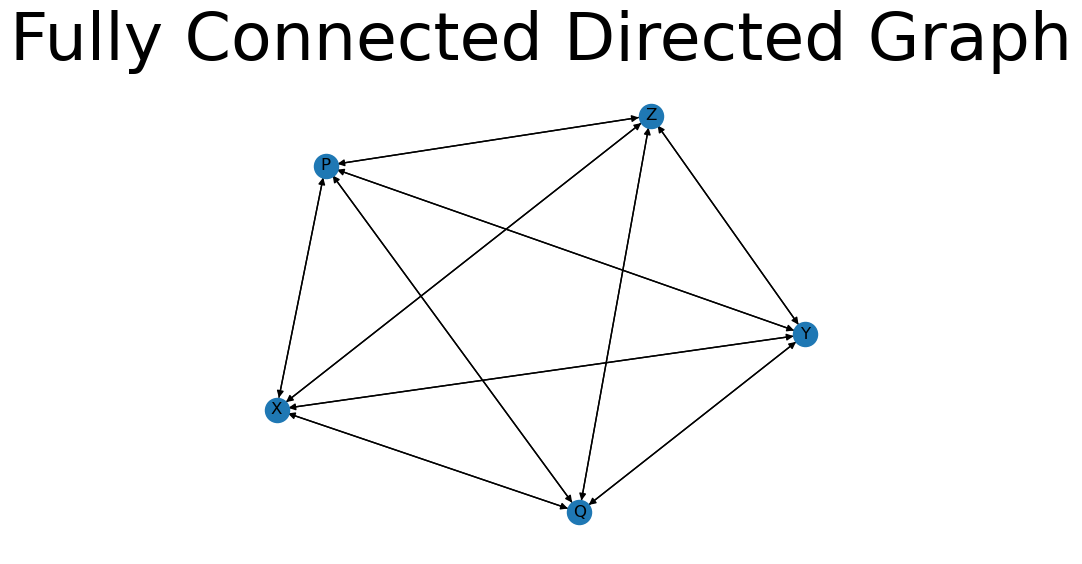

In [55]:
def plot_network(G, pos, title):
    nx.draw(G, pos, with_labels=True)
    plt.title(title)
    plt.show()

graph_list = []
for source, sinks in undirected_graph.items():
    for sink in sinks:
        graph_list.append((source, sink))
        G = nx.DiGraph()
G.add_edges_from(graph_list)
pos = nx.spring_layout(G)
plot_network(G, pos, "Fully Connected Directed Graph")

In [56]:
import copy
p_val = .005
def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        for c_var in control_vars:
            # set c_used every time use cycle through a new control
            #  the program will then iterate through remaining controls
            #  until statistical significance is broken
            c_used = copy.copy(controls_used)
            if y in undirected_graph[x]:

                c_used.append(c_var)
                test = df.partial_corr(x = x, y = y, covar=c_used,
                                      method = "pearson")
                if test["p-val"].values[0] > p_val: 

                    undirected_graph[x].remove(y)
                    #breakout of the for 
                    break
                else:
                    remaining_controls = copy.copy(control_vars)
                    remaining_controls.remove(c_var)
                    # recursive function that iterates through remaining variables 
                    #  uses them as controls statistical significance holds without them,
                    #  otherwise break
                    check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
                
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, 
                                       y = y, 
                                       covar = None,
                                       method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

undirected_graph = build_skeleton(df, undirected_graph)                                   
undirected_graph

{'P': ['Z'],
 'Q': ['X', 'Y'],
 'X': ['Q', 'Z'],
 'Y': ['Q', 'Z'],
 'Z': ['P', 'X', 'Y']}

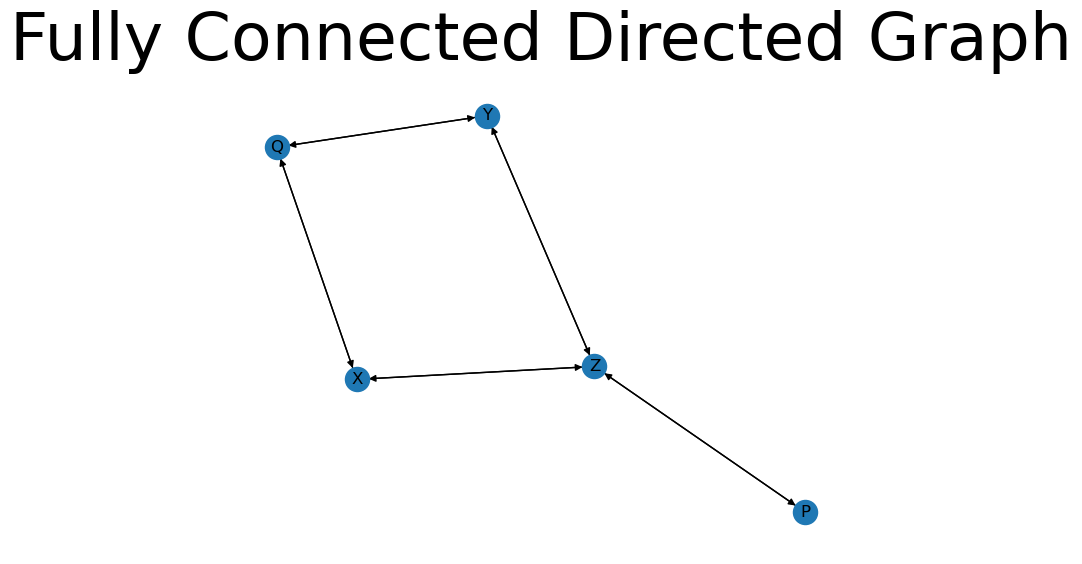

In [57]:
graph_list = []
for source, sinks in undirected_graph.items():
    for sink in sinks:
        graph_list.append((source, sink))
G = nx.DiGraph()
G.add_edges_from(graph_list)
pos = nx.spring_layout(G)
plot_network(G, pos, "Fully Connected Directed Graph")

### Infer Graphical Skeleton from Data

In [58]:
import matplotlib.pyplot as plt
import networkx as nx
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    
    # generate partial correlation matrix to draw values from
    # for graph edges
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = 1,
                     font_color = "white",
                     ax = ax)

    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    plt.show()

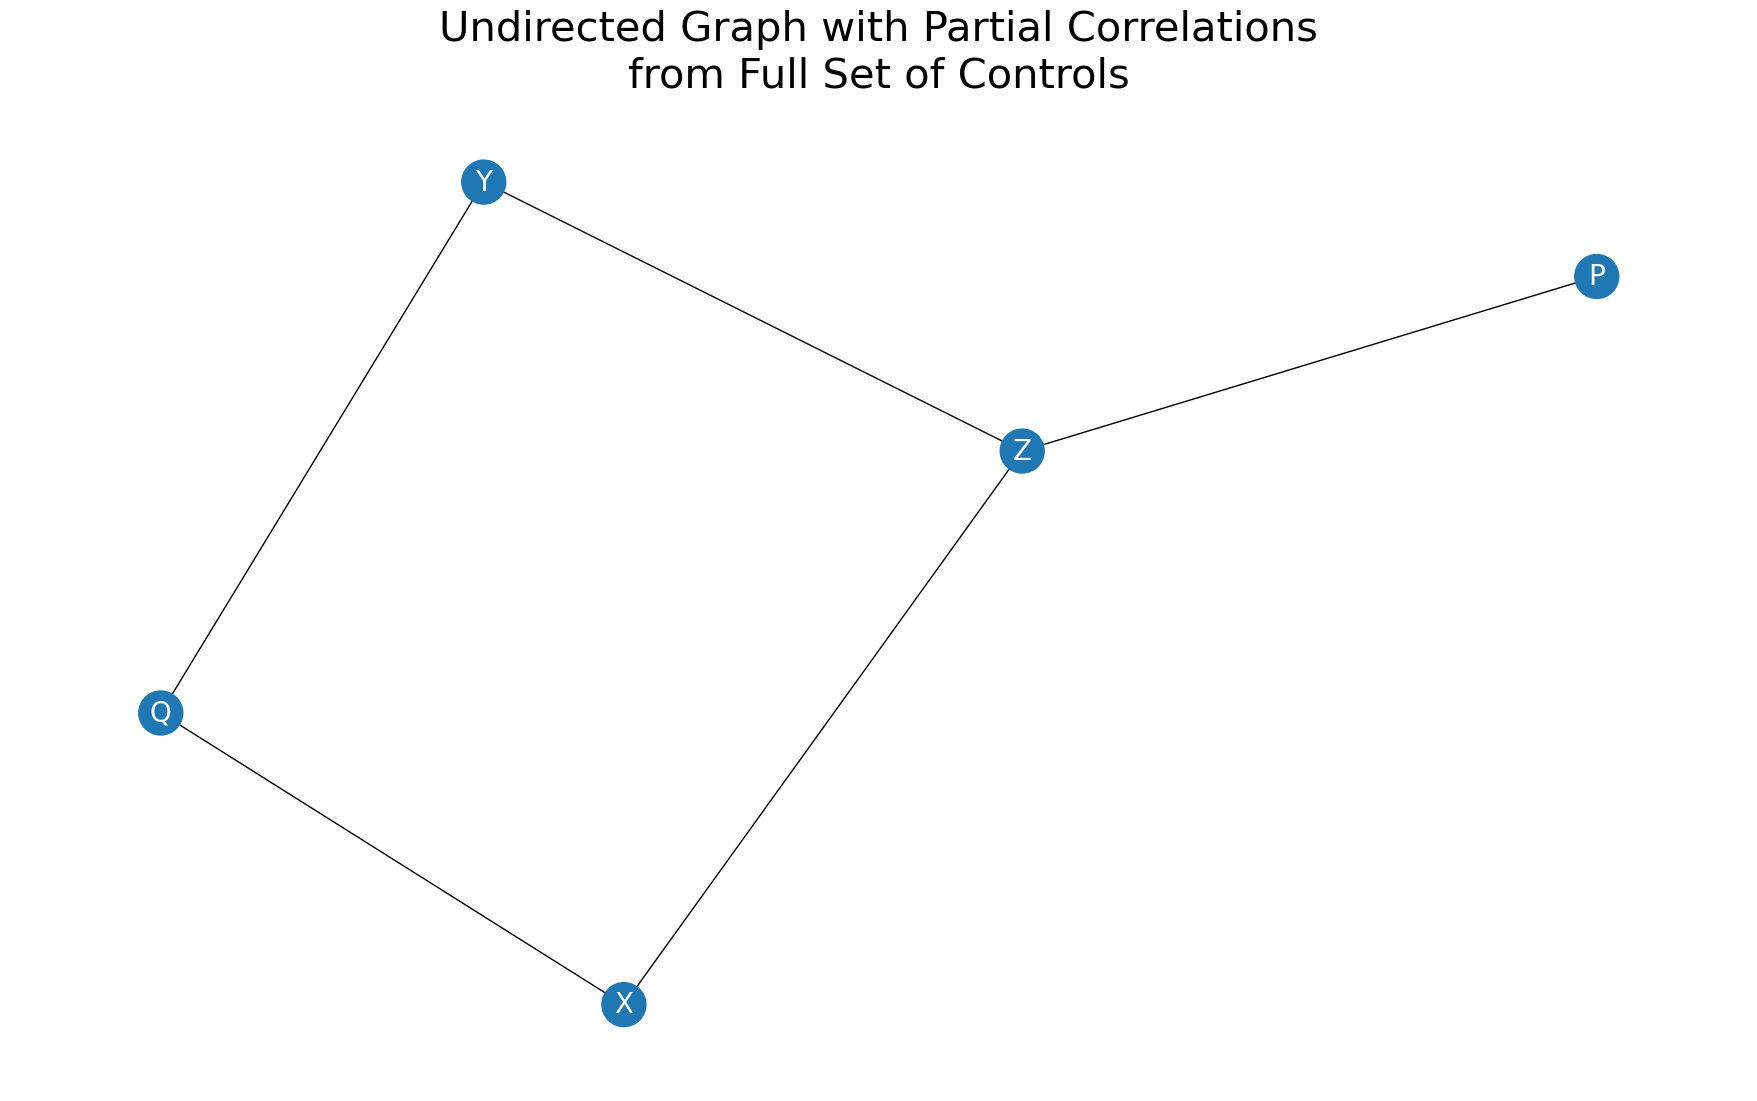

In [60]:
graph_DAG(undirected_graph, df, title = "Undirected Graph with Partial Correlations\nfrom Full Set of Controls")

In [59]:
!pip install pgmpy

In [60]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys()) - 2
model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


OutEdgeView([('P', 'Z'), ('Y', 'Z'), ('X', 'Z'), ('Q', 'X'), ('Q', 'Y')])

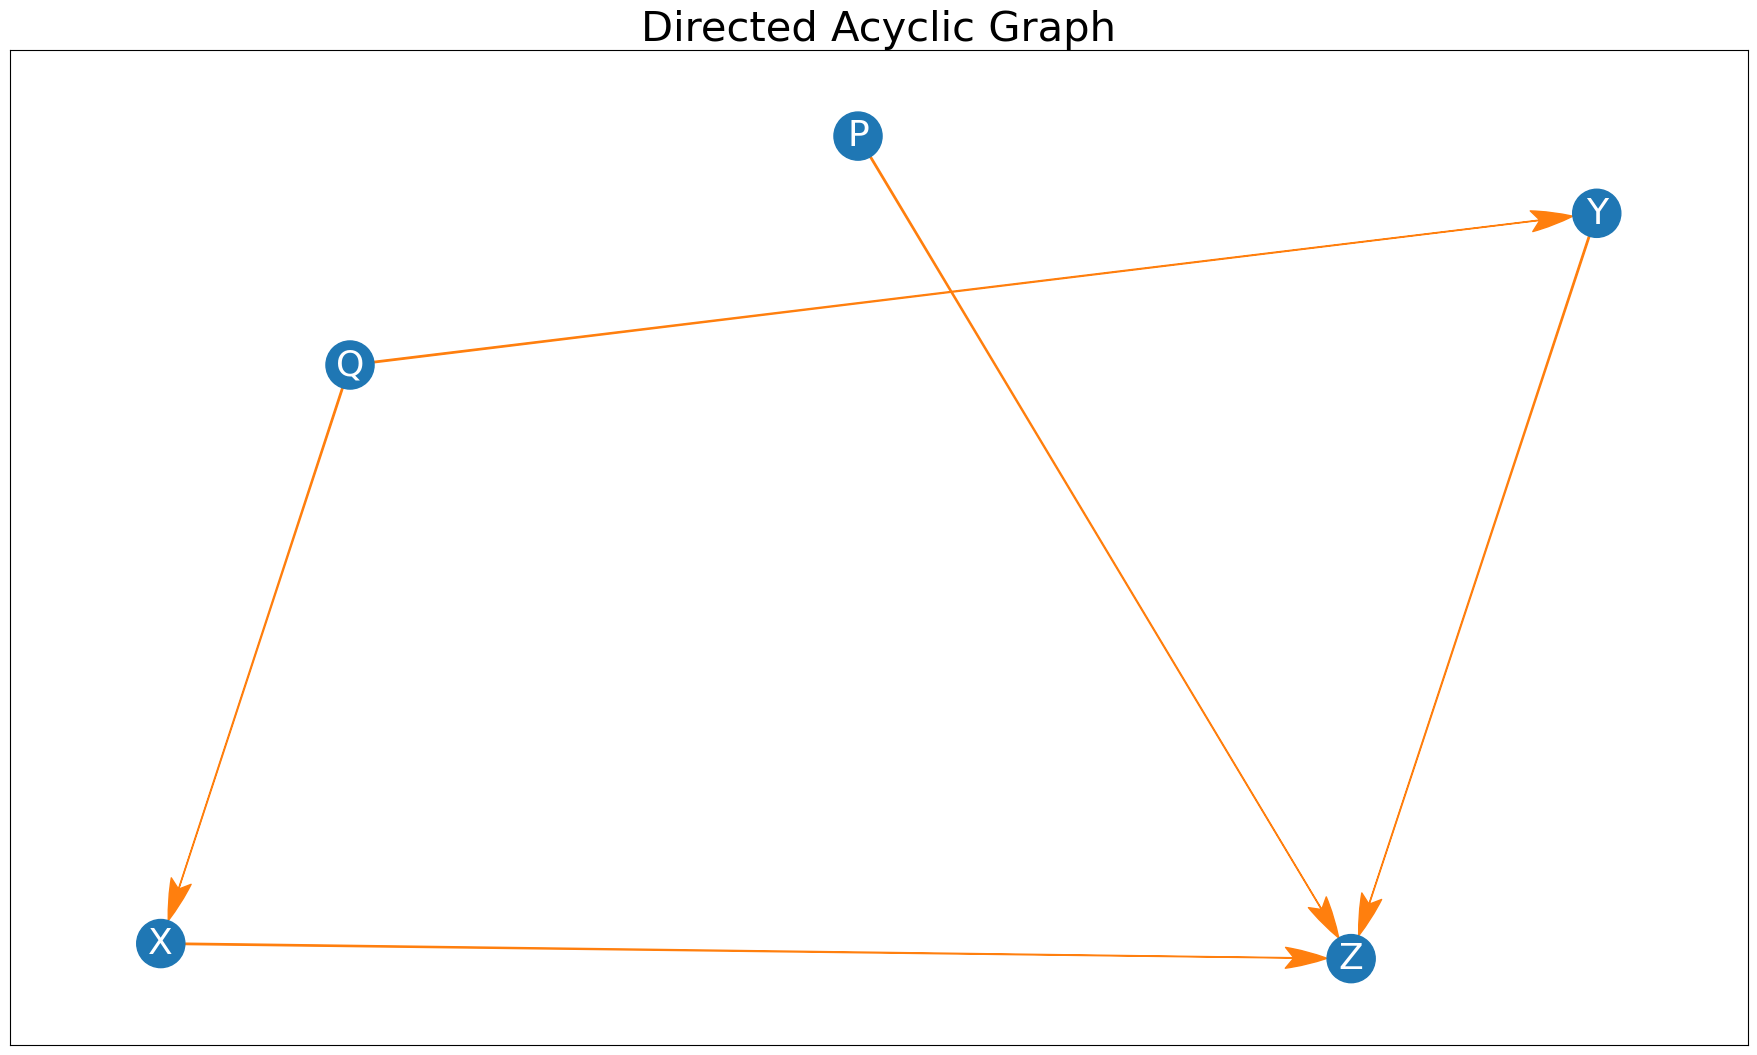

In [62]:
def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]
    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))
    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

keep control: Y
keep control: X
('P', 'Z') ['Y', 'X']
keep control: P
keep control: X
('Y', 'Z') ['P', 'X']
keep control: Y
keep control: P
('X', 'Z') ['Y', 'P']
('Q', 'X') []
('Q', 'Y') []


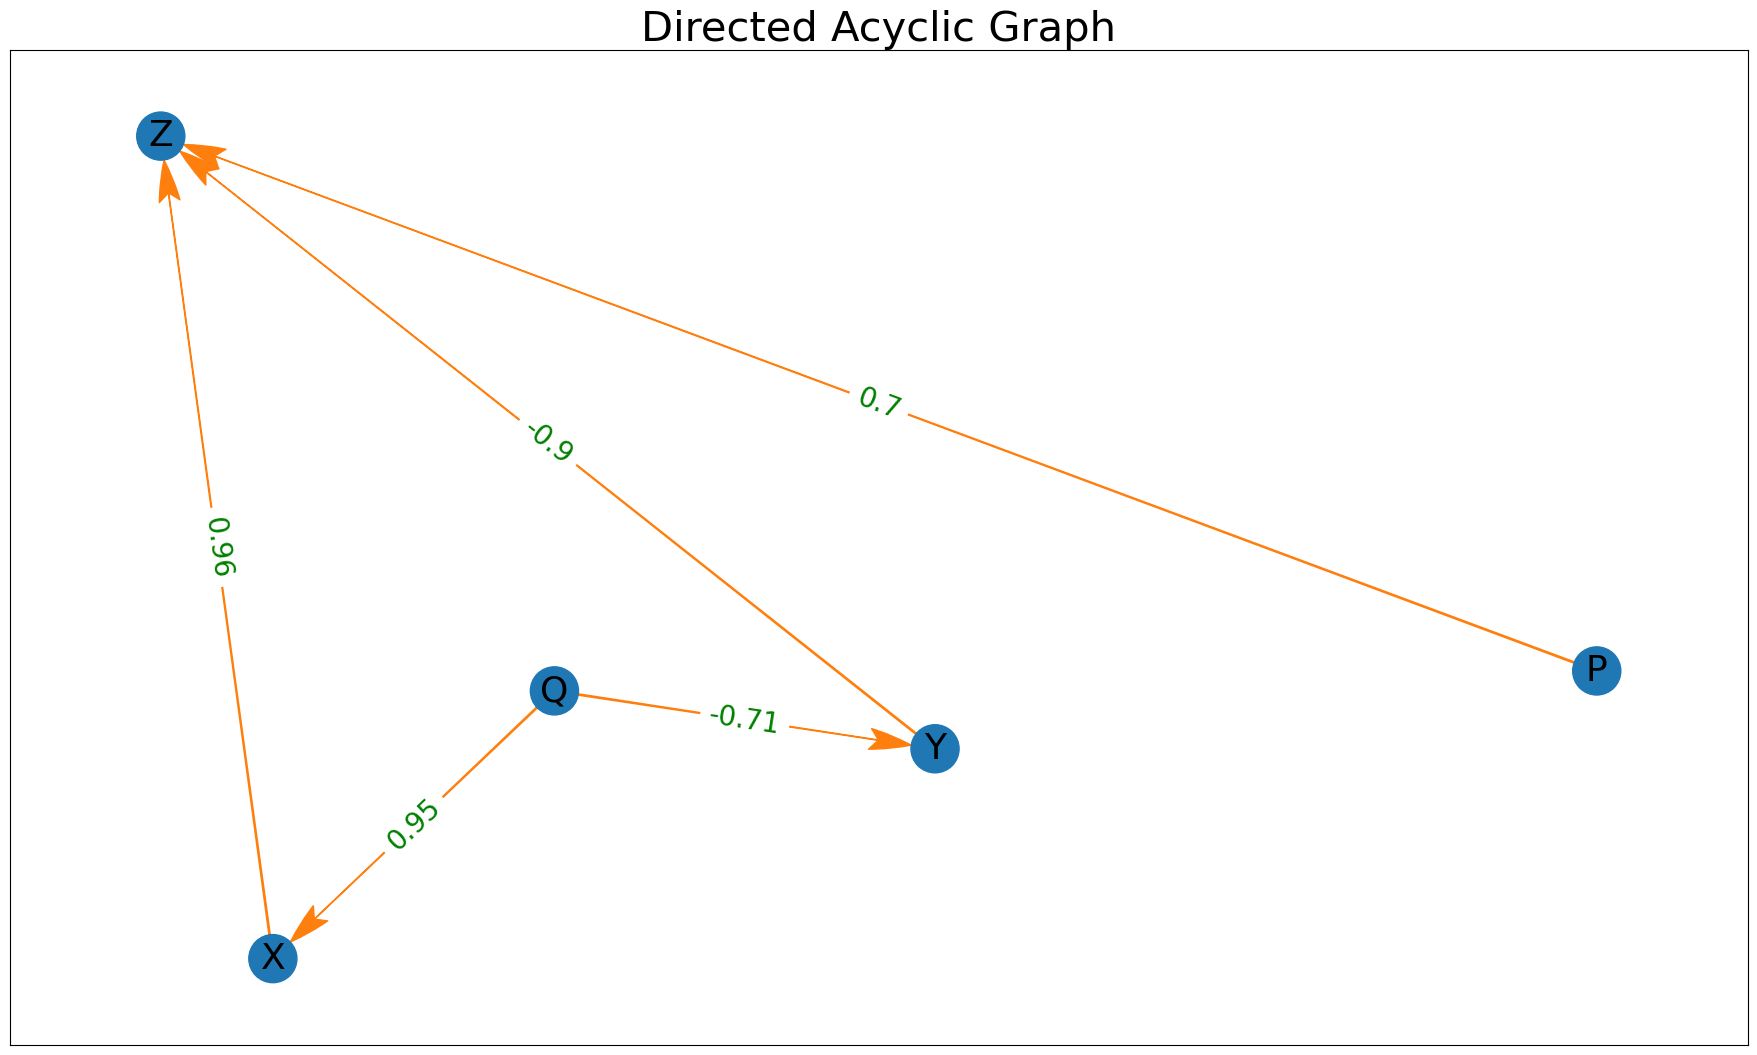

In [63]:
def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")